# Monetary Incentive Delay (MID) Task Analysis

This notebook analyzes reaction time (RT) data from the MID task, where participants respond to trials with different reward/punishment conditions. The code:
- Loads and cleans behavioral data
- Assigns trial types (e.g., Large_gain, Small_loss)
- Removes missed responses
- Visualizes RTs by trial type for all subjects and a specific subject (sub-1249)
- Performs statistical tests to compare RTs across conditions

## Setup
Import required libraries and configure plotting settings.

In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from natsort import natsorted
from scipy.io import loadmat
from scipy.stats import ttest_rel
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set matplotlib parameters
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.figsize'] = [8, 6]

## Load and Filter Outlier Data
Read the outlier runs file and filter out problematic runs. Create a subject-run identifier for matching.

In [4]:
sub_df = pd.read_csv('../../istart-mid/derivatives/OutlierRuns.tsv', sep='\t')
sub_df = sub_df[sub_df['outlier_run'] == False]
sub_df['sub_run'] = sub_df['Sub'] + '_' + sub_df['run'].astype(str)

## Load Behavioral Data
List all behavioral data files and display dataset information.

In [7]:
Mat_Beh_dir = '../../istart/Monetary_Incentive/data'
ML_EvFiles_list = natsorted([
    os.path.join(root, f) for root, _, files in os.walk(Mat_Beh_dir)
    for f in files if 'run' in f
])

print(f"Number of Subjects: {len([x for x in os.listdir(Mat_Beh_dir) if x.startswith('sub')])}")
print(f"Number of files: {len(ML_EvFiles_list)}")

Number of Subjects: 61
Number of files: 83


## Load and Process Run Conditions
Load trial conditions for runs 1 and 2, mapping numeric codes to descriptive trial types.

In [10]:
def load_run_conditions(run_num):
    run_cond = loadmat(f'{Mat_Beh_dir}/../timing/run{run_num}.mat')
    cond = run_cond['run']['cond'][0, 0].ravel()
    mapping = {
        '1': 'Large_gain', 1: 'Large_gain',
        '2': 'Large_loss', '3': 'Small_gain',
        '4': 'Small_loss', '5': 'Neutral'
    }
    return np.array([mapping.get(str(x), x) for x in cond])

run1, run2 = load_run_conditions(1), load_run_conditions(2)

## Process Behavioral Data
Load and structure data from .mat files into a DataFrame, assigning trial types based on run number.

In [13]:
data = []
for ML_EvFile in ML_EvFiles_list:
    sub = 'sub-' + re.search(r'sub-(.*?)/', ML_EvFile).group(1)
    run = re.search(r'run-(.*?)_out', ML_EvFile).group(1)
    
    mat = loadmat(ML_EvFile)
    mdata = mat['output']
    mdtype = mdata.dtype
    ndata = {n: mdata[n][0, 0] for n in mdtype.names}
    
    lens = [len(x[0]) for x in ndata.values()]
    if lens.count(lens[0]) == len(lens):
        df = pd.DataFrame(
            np.transpose(np.concatenate([ndata[c] for c in ndata])),
            columns=ndata.keys()
        )
        df['trial_type'] = run1[:len(df)] if run == '1' else run2
        df['sub'], df['run'] = sub, run
        data.append(df)

df = pd.concat(data, ignore_index=True)

## Clean Data
Remove missed responses (RT <= 0.01) and calculate the number of missed trials.

In [16]:
df = df[df['RT'] > 0.01]

misses = [
    len(tmp[(tmp['RT'] == 0) & (tmp['outcome'] == 0)])
    for sub in df['sub'].unique()
    for run in df[df['sub'] == sub]['run'].unique()
    for tmp in [df[(df['sub'] == sub) & (df['run'] == run)]]
]
print(f"Maximum missed trials: {np.max(misses)} (less than 20% of trials)")

Maximum missed trials: 0 (less than 20% of trials)


## Assign Trial Codes
Map trial types to numeric codes for analysis and ensure run is integer type.

In [19]:
df['Trial_code'] = df['trial_type'].map({
    'Large_loss': -2, 'Small_loss': -1, 'Neutral': 0,
    'Small_gain': 1, 'Large_gain': 2
})
df['run'] = df['run'].astype(int)

## Group Data for Analysis
Calculate median RTs by subject and trial type for downstream analysis.

In [22]:
group_df = df.groupby(['sub', 'trial_type']).median(numeric_only=True).reset_index()

## Visualize Individual Subject RTs
Create a bar plot of median RTs for subject sub-1249.

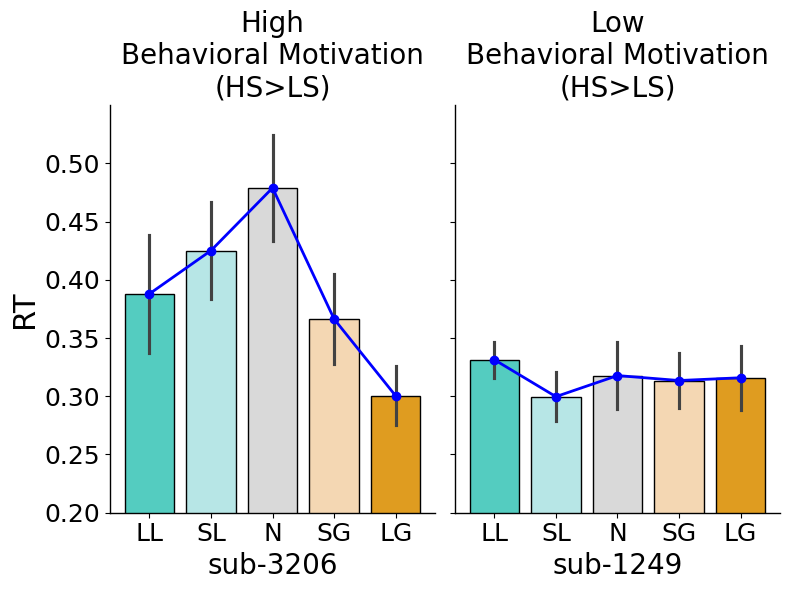

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assume df is loaded; replace with actual load if needed
# df = pd.read_excel('~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx')

# Visualize RTs for two subjects in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 6))

# Define subjects and their titles
subjects = [('sub-3206', 'High\nBehavioral Motivation\n(HS>LS)'), ('sub-1249', 'Low\nBehavioral Motivation\n(HS>LS)')]
gradient_palette = ["#40E0D0", "#AFEEEE", "#D9D9D9", "#FFD8A8", "#FFA500"]

# X-tick labels mapping
tick_labels = ['LL', 'SL', 'N', 'SG', 'LG']

for ax, (sub_id, main_title) in zip([ax1, ax2], subjects):
    sub_df = df[df['sub'] == sub_id]
    
    # Bar plot with SEM error bars
    g = sns.barplot(
        x='Trial_code', y='RT', data=sub_df,
        errorbar='se', hue='Trial_code', palette=gradient_palette, legend=False, ax=ax
    )
    
    # Calculate mean RTs for trendline
    means = sub_df.groupby('Trial_code')['RT'].mean().reindex([-2, -1, 0, 1, 2])
    
    # Add trendline
    ax.plot(range(len(means)), means.values, color='blue', linewidth=2, marker='o')
    
    # Formatting
    ax.set_ylim(0.2, 0.55)
    ax.set_xticks(range(5))
    ax.set_xticklabels(tick_labels, fontsize=18)
    ax.set_yticks([0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
    ax.set_yticklabels([f'{x:.2f}' for x in ax.get_yticks()], fontsize=18)
    ax.set_xlabel(sub_id, fontsize=20)
    ax.set_ylabel('RT' if ax == ax1 else '', fontsize=22)
    ax.set_title(main_title, fontsize=20)
    for bar in ax.patches:
        bar.set_edgecolor("black")
        bar.set_linewidth(1)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color("black")
    ax.spines[['left', 'bottom']].set_linewidth(1)

# Tighten spacing without overlap
plt.subplots_adjust(wspace=0.2)
plt.tight_layout()
plt.savefig('sub-3206-1249-RT.svg', format='svg')
plt.show()

## Visualize Group RTs
Create a bar plot of median RTs by trial type across all subjects.

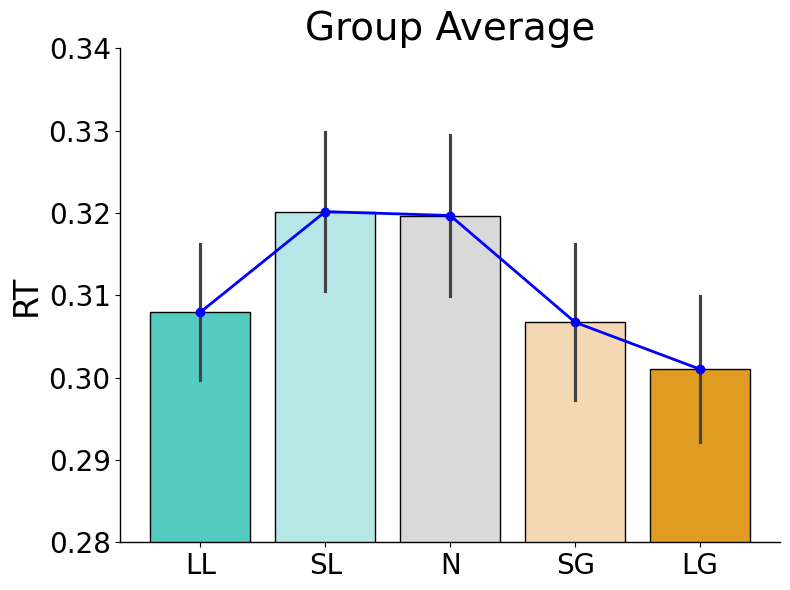

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assume group_df is loaded; replace with actual load if needed
# group_df = pd.read_excel('~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx')

# Visualize group RTs
gradient_palette = ["#40E0D0", "#AFEEEE", "#D9D9D9", "#FFD8A8", "#FFA500"]
tick_labels = ['LL', 'SL', 'N', 'SG', 'LG']

g = sns.barplot(
    x='Trial_code', y='RT', data=group_df,
    errorbar='se', hue='Trial_code', palette=gradient_palette, legend=False
)
#plt.yscale('log')  # Apply logarithmic scale
#plt.yticks([0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
#plt.gca().set_yticklabels([f'{x:.2f}' for x in plt.gca().get_yticks()], fontsize=20)
plt.xticks(range(5), tick_labels, fontsize=20)
plt.ylim(0.28, 0.34)
plt.yticks(fontsize=20)
plt.xlabel('', fontsize=24)
plt.ylabel('RT', fontsize=24)
plt.title('Group Average', fontsize=28)
for bar in g.patches:
    bar.set_edgecolor("black")
    bar.set_linewidth(1)
g.spines[['top', 'right']].set_visible(False)
g.spines[['left', 'bottom']].set_color("black")
g.spines[['left', 'bottom']].set_linewidth(1)

# Add trendline
means = group_df.groupby('Trial_code')['RT'].mean().reindex([-2, -1, 0, 1, 2])
plt.plot(range(len(means)), means.values, color='blue', linewidth=2, marker='o')

plt.tight_layout()
plt.savefig('group-RT.svg', format='svg')
plt.show()

## Statistical Tests
Perform paired t-tests to compare RTs between trial types (Large_gain vs. Neutral, Large_loss vs. Neutral).

In [32]:
import pandas as pd
import subprocess
import os

# Step 1: Read in the data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Step 2: Reshape to long format
df_long = df.melt(
    id_vars='Sub', 
    value_vars=['Beh_LG', 'Beh_SG', 'Beh_N', 'Beh_SL', 'Beh_LL'],
    var_name='Condition',
    value_name='Value'
)

# Step 3: Clean up condition labels
condition_map = {
    'Beh_LG': 'Large Gain',
    'Beh_SG': 'Small Gain',
    'Beh_N': 'Neutral',
    'Beh_SL': 'Small Loss',
    'Beh_LL': 'Large Loss'
}
df_long['Condition'] = df_long['Condition'].map(condition_map)

# First run the Python-only ANOVA for reference
from statsmodels.stats.anova import AnovaRM
aovrm = AnovaRM(data=df_long, depvar='Value', subject='Sub', within=['Condition'])
aovrm_results = aovrm.fit()
print("\nPython Repeated Measures ANOVA Results:\n")
print(aovrm_results)

# Save the long format data to a CSV file
csv_path = 'long_format_data.csv'
df_long.to_csv(csv_path, index=False)

# Create an R script file
r_script_path = 'run_emmeans_analysis.R'
with open(r_script_path, 'w') as f:
    f.write("""
# Load required packages
library(emmeans)

# Read the data
data <- read.csv('long_format_data.csv')

# Make Condition a factor with the correct levels
data$Condition <- factor(data$Condition, 
                         levels = c("Large Gain", "Small Gain", "Neutral", "Small Loss", "Large Loss"))
data$Sub <- factor(data$Sub)  # Ensure Sub is treated as a factor

# Run the repeated measures ANOVA
anova_results <- aov(Value ~ Condition + Error(Sub/Condition), data = data)

# Print the ANOVA results
cat("\\nR ANOVA Results:\\n")
print(summary(anova_results))

# Compute emmeans for the model
emm <- emmeans(anova_results, ~ Condition)

# Compute all pairwise comparisons
pairwise_comparisons <- contrast(emm, method = "pairwise", adjust = "tukey")

# Print all pairwise comparisons
cat("\\nR Pairwise Comparisons:\\n")
pairwise_summary <- summary(pairwise_comparisons)
print(pairwise_summary)

# Save the results to a CSV file
write.csv(as.data.frame(pairwise_summary), 'r_pairwise_results.csv', row.names = FALSE)
""")

# Run the R script
try:
    result = subprocess.run(['Rscript', r_script_path], 
                           capture_output=True, text=True, check=True)
    print(result.stdout)
    if result.stderr:
        print("R warnings/errors:", result.stderr)
except subprocess.CalledProcessError as e:
    print("Error running R script:", e)
    print("R output:", e.stdout)
    print("R error:", e.stderr)
    
# Read the results back into Python
try:
    if os.path.exists('r_pairwise_results.csv'):
        r_results = pd.read_csv('r_pairwise_results.csv')
        print("\nR pairwise results loaded into Python:\n")
        print(r_results)
    else:
        print("R result file not found.")
except Exception as e:
    print("Error reading R results:", e)


Python Repeated Measures ANOVA Results:

                 Anova
          F Value Num DF  Den DF  Pr > F
----------------------------------------
Condition  5.0219 4.0000 180.0000 0.0007


R ANOVA Results:

Error: Sub
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 45 0.5617 0.01248               

Error: Sub:Condition
           Df  Sum Sq  Mean Sq F value   Pr(>F)    
Condition   4 0.01646 0.004116   5.022 0.000735 ***
Residuals 180 0.14752 0.000820                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R Pairwise Comparisons:
 contrast                 estimate      SE  df t.ratio p.value
 Large Gain - Small Gain -0.007629 0.00597 180  -1.278  0.7050
 Large Gain - Neutral    -0.021040 0.00597 180  -3.525  0.0048
 Large Gain - Small Loss -0.016521 0.00597 180  -2.768  0.0484
 Large Gain - Large Loss -0.000424 0.00597 180  -0.071  1.0000
 Small Gain - Neutral    -0.013411 0.00597 180  -2.247  0.1675
 Small Gain - Small Loss -0.008892 0.00597 180 

## Correlation Heatmap
Create a correlation heatmap for selected variables (`comp_RS`, `score_teps_ant`, `V_beta`, `LG_N_new`, `LL_N_new`), showing Pearson correlations in a lower triangle format, styled to match previous plots.

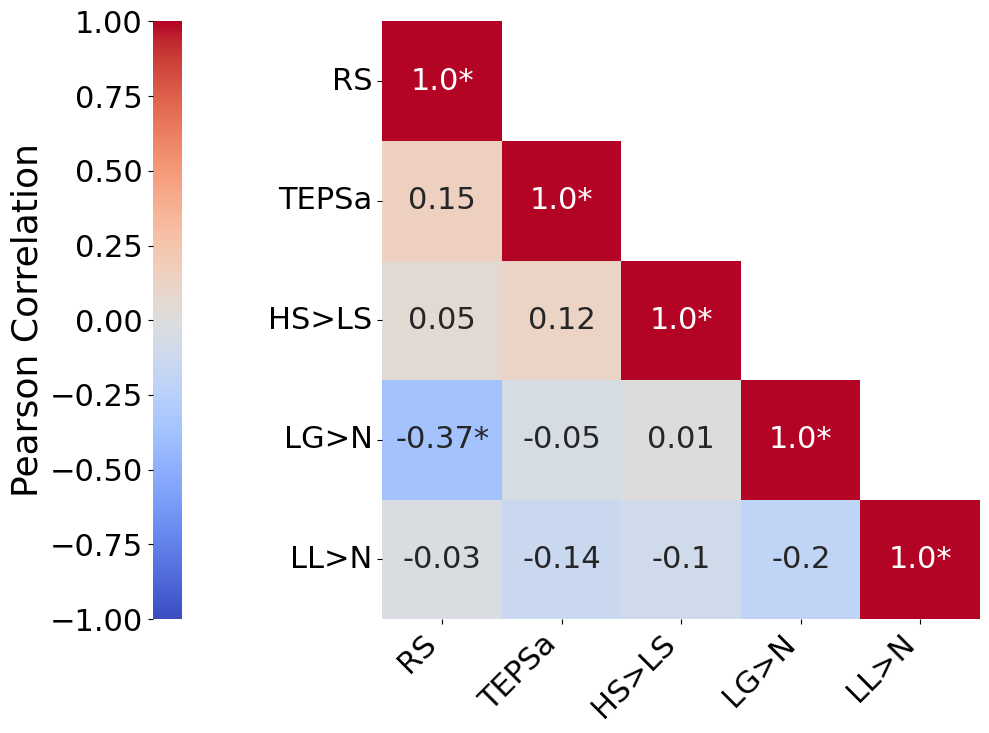

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load the data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Map original column names to new display names
name_mapping = {
    'comp_RS': 'RS',
    'score_teps_ant': 'TEPSa',
    'V_beta': 'HS>LS',
    'LG_N_new': 'LG>N',
    'LL_N_new': 'LL>N'
}

corr_cols = list(name_mapping.keys())
corr_df = df[corr_cols].dropna()

# Compute correlation matrix and p-values
cormat = corr_df.corr(method='pearson').round(2)
pvals = pd.DataFrame(np.zeros_like(cormat), index=cormat.index, columns=cormat.columns)

for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        _, pvals.iloc[i, j] = pearsonr(corr_df[corr_cols[i]], corr_df[corr_cols[j]])

# Annotate all cells, including diagonal
annot = cormat.copy().astype(str)
annot[pvals < 0.05] = annot[pvals < 0.05] + '*'

# Rename for plotting
cormat.columns = [name_mapping[col] for col in cormat.columns]
cormat.index = [name_mapping[col] for col in cormat.index]
annot.columns = cormat.columns
annot.index = cormat.index

# Mask upper triangle only
mask = np.triu(np.ones_like(cormat, dtype=bool), k=1)

# Set up figure
fig, ax = plt.subplots(figsize=(10, 8))

# Create separate colorbar axis with more padding
divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="5%", pad=2)

# Plot heatmap
g = sns.heatmap(
    cormat, mask=mask, annot=annot, fmt='', cmap='coolwarm',
    vmin=-1, vmax=1, center=0, square=True, edgecolors='black',
    annot_kws={'size': 22},  # slightly increased
    cbar_ax=cax, cbar_kws={'label': 'Pearson Correlation'},
    ax=ax
)

# Tick labels
tick_fontsize = 22
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right', fontsize=tick_fontsize)
g.set_yticklabels(g.get_yticklabels(), rotation=0, ha='right', fontsize=tick_fontsize)

# Colorbar styling
cax.yaxis.set_label_position('left')
cax.yaxis.set_ticks_position('left')
cax.yaxis.label.set_size(26)
cax.tick_params(labelsize=tick_fontsize)  # match tick font size to heatmap

# Remove spines
for spine in g.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig('correlation_heatmap.svg', format='svg', bbox_inches='tight')
plt.show()



## Scatterplot of Behavioral Motivation vs. Reward Sensitivity by TEPSa
Create a scatterplot of `V_beta` (Behavioral Motivation) vs. `comp_RS` (Reward Sensitivity), colored by `teps_ant_split`, with regression lines, styled to match previous plots.

Created teps_ant_split successfully.

low group size before regression: 23
Added regression line for low

high group size before regression: 23
Added regression line for high


/var/folders/m6/p7f91dqd37d_mdjnjbx6xdy80000gn/T/ipykernel_88286/2252522159.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), fontsize=20)
/var/folders/m6/p7f91dqd37d_mdjnjbx6xdy80000gn/T/ipykernel_88286/2252522159.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels([f'{x:.2f}' for x in g.get_yticks()], fontsize=20)


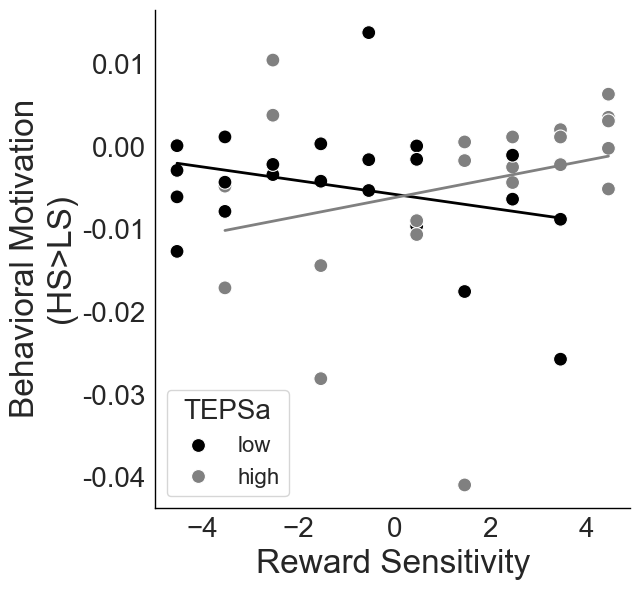


Linear Model Summary:
                            OLS Regression Results                            
Dep. Variable:                 V_beta   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     2.973
Date:                Thu, 15 May 2025   Prob (F-statistic):             0.0303
Time:                        14:06:21   Log-Likelihood:                 154.96
No. Observations:                  46   AIC:                            -299.9
Df Residuals:                      41   BIC:                            -290.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Inter

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Load the data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Drop rows with missing comp_RS or V_beta (none expected)
df_plot = df[['comp_RS', 'V_beta', 'score_teps_ant']].dropna().copy()

if df_plot.empty:
    print("Error: No valid data after dropping missing values. Cannot create plot.")
else:
    # Create teps_ant_split
    if 'teps_ant_split' not in df_plot.columns:
        if df_plot['score_teps_ant'].isna().all():
            print("Error: 'score_teps_ant' contains all NaN. Cannot create teps_ant_split.")
            df_plot['teps_ant_split'] = 'All'
        else:
            try:
                df_plot['teps_ant_split'] = pd.qcut(df_plot['score_teps_ant'], 2, labels=['low', 'high'])
                print("Created teps_ant_split successfully.")
            except ValueError as e:
                print(f"Error creating teps_ant_split: {e}. Using single group.")
                df_plot['teps_ant_split'] = 'All'

    # Create scatterplot
    plt.figure(figsize=(6.5, 6))
    g = sns.scatterplot(
        x='comp_RS', y='V_beta', hue='teps_ant_split', style='teps_ant_split',
        data=df_plot, palette=['black', 'gray'], markers=['o', 'o'], s=100
    )

    # Add regression lines without shaded error regions
    for group in ['low', 'high']:
        group_df = df_plot[df_plot['teps_ant_split'] == group]
        print(f"\n{group} group size before regression: {len(group_df)}")
        if len(group_df) >= 2:
            try:
                sns.regplot(
                    x='comp_RS', y='V_beta', data=group_df,
                    scatter=False, color='black' if group == 'low' else 'gray',
                    line_kws={'linestyle': 'solid', 'linewidth': 2},
                    ci=None,
                    ax=g
                )
                print(f"Added regression line for {group}")
            except Exception as e:
                print(f"Error adding regression line for {group}: {e}")
        else:
            print(f"Warning: Insufficient data for {group} regression line (n={len(group_df)}).")

    # Formatting
    plt.xlabel('Reward Sensitivity', fontsize=24)
    plt.ylabel('Behavioral Motivation\n(HS>LS)', fontsize=24)
    plt.title('', fontsize=28)
    g.set_xticklabels(g.get_xticklabels(), fontsize=20)
    g.set_yticklabels([f'{x:.2f}' for x in g.get_yticks()], fontsize=20)
    g.legend(title='TEPSa', fontsize=16, title_fontsize=20, loc='lower left')

    # Remove spines and grid
    g.spines[['top', 'right']].set_visible(False)
    g.spines[['left', 'bottom']].set_color('black')
    g.spines[['left', 'bottom']].set_linewidth(1)
    g.set_facecolor('white')
    g.grid(False)

    plt.tight_layout()
    plt.savefig('scatter_teps_rs.svg', format='svg')
    plt.show()

# Run linear model
print("\nLinear Model Summary:")
model = smf.ols('V_beta ~ score_teps_con + comp_RS * score_teps_ant', data=df).fit()
print(model.summary())

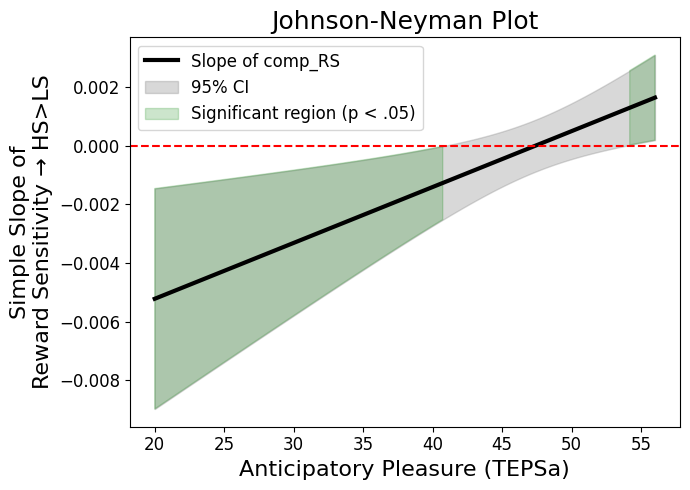

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
import statsmodels.api as sm
from scipy.stats import norm

# Load and clean data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)
df_plot = df[['comp_RS', 'V_beta', 'score_teps_con', 'score_teps_ant']].dropna().copy()

# Fit linear model with interaction
model = smf.ols('V_beta ~ score_teps_con + comp_RS * score_teps_ant', data=df_plot).fit()

# Create a grid of moderator values (score_teps_ant)
mod_range = np.linspace(df_plot['score_teps_ant'].min(), df_plot['score_teps_ant'].max(), 100)

# Compute simple slopes of comp_RS at each level of the moderator
simple_slopes = []
stderr = []
pvals = []

score_teps_con_mean = df_plot['score_teps_con'].mean()

for value in mod_range:
    # Create temporary dataframe for this level of moderator
    temp_df = pd.DataFrame({
        'comp_RS': df_plot['comp_RS'],
        'score_teps_ant': value,
        'score_teps_con': score_teps_con_mean
    })

    # Compute marginal effect of comp_RS at this level
    # This is done using the model's parameters: slope = b1 + b3*mod_value
    # and the variance of the estimate
    params = model.params
    cov = model.cov_params()

    # Slope of comp_RS at this level of moderator
    slope = params['comp_RS'] + params['comp_RS:score_teps_ant'] * value
    simple_slopes.append(slope)

    # Compute standard error of the simple slope
    se = np.sqrt(
        cov.loc['comp_RS', 'comp_RS'] +
        2 * value * cov.loc['comp_RS', 'comp_RS:score_teps_ant'] +
        value ** 2 * cov.loc['comp_RS:score_teps_ant', 'comp_RS:score_teps_ant']
    )
    stderr.append(se)

    # Compute p-value for test of slope = 0
    tval = slope / se
    pval = 2 * (1 - norm.cdf(np.abs(tval)))
    pvals.append(pval)

simple_slopes = np.array(simple_slopes)
stderr = np.array(stderr)
pvals = np.array(pvals)

# Confidence intervals
lower = simple_slopes - 1.96 * stderr
upper = simple_slopes + 1.96 * stderr

# Plotting
plt.figure(figsize=(7, 5))
plt.plot(mod_range, simple_slopes, color='black', linewidth=3, label='Slope of comp_RS')
plt.fill_between(mod_range, lower, upper, color='gray', alpha=0.3, label='95% CI')

# Highlight regions where the slope is significant
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.fill_between(mod_range, lower, upper, where=(pvals < 0.05), color='green', alpha=0.2, label='Significant region (p < .05)')

# Labels and formatting
plt.xlabel('Anticipatory Pleasure (TEPSa)', fontsize=16)
plt.ylabel('Simple Slope of\nReward Sensitivity → HS>LS', fontsize=16)
plt.title('Johnson-Neyman Plot', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('johnson_neyman_plot.svg', format='svg')
plt.show()


### At low levels of anticipatory pleasure (TEPSa < ~40):

- The slope of Reward Sensitivity → Behavioral Motivation (HS>LS) is negative and significant.
- Interpretation: Among people lower in anticipatory pleasure, greater reward sensitivity predicts lesser behavioral motivation (i.e., weaker reaction time differences for high vs low stakes).

### At moderate levels of TEPSa (~40–54):

- The slope is not statistically different from zero.
- Interpretation: Among people with average levels of anticipatory pleasure, reward sensitivity doesn’t significantly predict behavioral motivation. The relationship flattens out.

### At high levels of TEPSa (~54–55):

- The slope becomes significant again and positive.
- Interpretation: For people high in anticipatory pleasure, greater reward sensitivity once again predicts greater behavioral motivation.

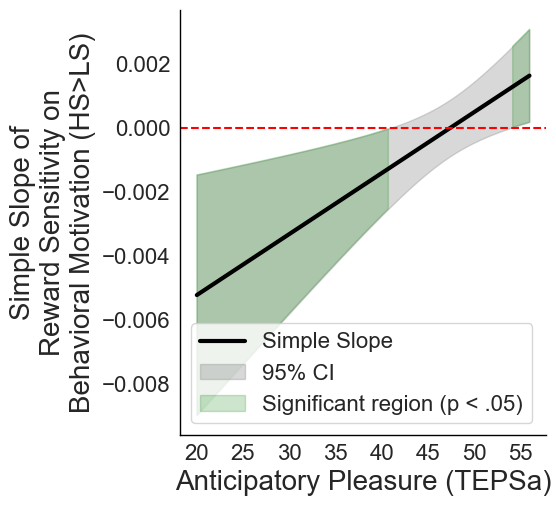


Linear Model Summary:
                            OLS Regression Results                            
Dep. Variable:                 V_beta   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     2.973
Date:                Thu, 15 May 2025   Prob (F-statistic):             0.0303
Time:                        15:57:18   Log-Likelihood:                 154.96
No. Observations:                  46   AIC:                            -299.9
Df Residuals:                      41   BIC:                            -290.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Inter

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
from scipy.stats import norm

# Set seaborn style
sns.set_style("white", {"axes.linecolor": "black", "axes.edgecolor": "black"})

# Load and clean data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)
df_plot = df[['comp_RS', 'V_beta', 'score_teps_con', 'score_teps_ant']].dropna().copy()

if df_plot.empty:
    print("Error: No valid data after dropping missing values. Cannot create plot.")
else:
    # Fit linear model with interaction
    model = smf.ols('V_beta ~ score_teps_con + comp_RS * score_teps_ant', data=df_plot).fit()

    # Create a grid of moderator values (score_teps_ant)
    mod_range = np.linspace(df_plot['score_teps_ant'].min(), df_plot['score_teps_ant'].max(), 100)

    # Compute simple slopes of comp_RS at each level of the moderator
    simple_slopes = []
    stderr = []
    pvals = []

    score_teps_con_mean = df_plot['score_teps_con'].mean()

    # Extract model parameters and covariance matrix
    params = model.params
    cov = model.cov_params()

    for value in mod_range:
        # Slope of comp_RS at this level of moderator
        slope = params['comp_RS'] + params['comp_RS:score_teps_ant'] * value
        simple_slopes.append(slope)

        # Compute standard error of the simple slope
        se = np.sqrt(
            cov.loc['comp_RS', 'comp_RS'] +
            2 * value * cov.loc['comp_RS', 'comp_RS:score_teps_ant'] +
            value ** 2 * cov.loc['comp_RS:score_teps_ant', 'comp_RS:score_teps_ant']
        )
        stderr.append(se)

        # Compute p-value for test of slope = 0
        tval = slope / se
        pval = 2 * (1 - norm.cdf(np.abs(tval)))
        pvals.append(pval)

    simple_slopes = np.array(simple_slopes)
    stderr = np.array(stderr)
    pvals = np.array(pvals)

    # Confidence intervals
    lower = simple_slopes - 1.96 * stderr
    upper = simple_slopes + 1.96 * stderr

    # Plotting
    plt.figure(figsize=(5.5, 5))
    plt.plot(mod_range, simple_slopes, color='black', linewidth=3, label='Simple Slope')
    plt.fill_between(mod_range, lower, upper, color='gray', alpha=0.3, label='95% CI')

    # Highlight regions where the slope is significant
    plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
    plt.fill_between(mod_range, lower, upper, where=(pvals < 0.05), color='green', alpha=0.2, label='Significant region (p < .05)')

    # Labels and formatting
    plt.xlabel('Anticipatory Pleasure (TEPSa)', fontsize=20)
    plt.ylabel('Simple Slope of\nReward Sensitivity on\nBehavioral Motivation (HS>LS)', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16, loc='best')
    plt.xlim(mod_range.min() - 0.05 * (mod_range.max() - mod_range.min()),
             mod_range.max() + 0.05 * (mod_range.max() - mod_range.min()))
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.gca().spines[['left', 'bottom']].set_color('black')
    plt.gca().spines[['left', 'bottom']].set_linewidth(1)
    plt.gca().set_facecolor('white')
    plt.grid(False)

    plt.tight_layout(pad=0.5)
    plt.savefig('johnson_neyman_plot.svg', format='svg')
    plt.show()

    # Print linear model summary
    print("\nLinear Model Summary:")
    print(model.summary())

    # Print regions of significance
    print("\nJohnson-Neyman Analysis:")
    sig_points = mod_range[pvals < 0.05]
    if len(sig_points) > 0:
        print(f"Regions of significance (p < 0.05) for score_teps_ant: {sig_points.min():.3f} to {sig_points.max():.3f}")
    else:
        print("No regions of significance found (p >= 0.05 for all score_teps_ant values).")

Created teps_ant_split successfully.
Predicted range: -0.00963101053757126 to -0.00018643742796437904
SEM range: 0.0025206715366870476 to 0.0030086230944232403


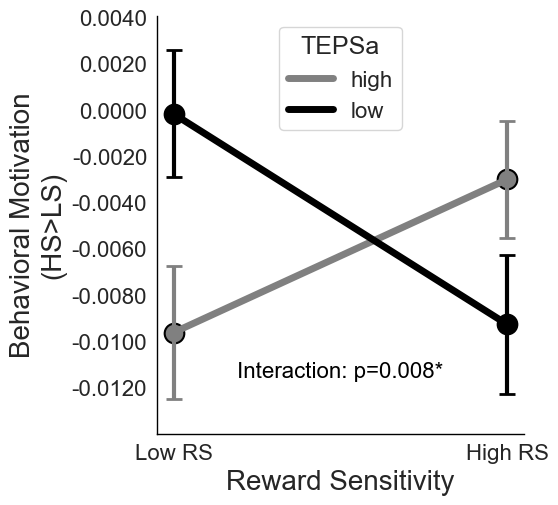


Linear Model Summary:
                            OLS Regression Results                            
Dep. Variable:                 V_beta   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     2.973
Date:                Tue, 13 May 2025   Prob (F-statistic):             0.0303
Time:                        08:15:26   Log-Likelihood:                 154.96
No. Observations:                  46   AIC:                            -299.9
Df Residuals:                      41   BIC:                            -290.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Inter

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np

# Set seaborn style
sns.set_style("white", {"axes.linecolor": "black", "axes.edgecolor": "black"})

# Load data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Drop missing values
df_plot = df[['comp_RS', 'V_beta', 'score_teps_con', 'score_teps_ant']].dropna().copy()

if df_plot.empty:
    print("Error: No valid data after dropping missing values. Cannot create plot.")
else:
    # Create teps_ant_split
    if 'teps_ant_split' not in df_plot.columns or df_plot['score_teps_ant'].isna().all():
        print("Warning: 'teps_ant_split' missing or 'score_teps_ant' all NaN. Creating split.")
        try:
            df_plot['teps_ant_split'] = pd.qcut(df_plot['score_teps_ant'], 2, labels=['low', 'high'])
            print("Created teps_ant_split successfully.")
        except ValueError as e:
            print(f"Error creating teps_ant_split: {e}. Using single group.")
            df_plot['teps_ant_split'] = 'All'
    else:
        df_plot['teps_ant_split'] = df_plot['teps_ant_split'].astype(str).str.lower()

    # Fit linear model
    model = smf.ols('V_beta ~ score_teps_con + comp_RS * score_teps_ant', data=df_plot).fit()

    # Create prediction data
    levels = sorted(df_plot['teps_ant_split'].unique())
    comp_RS_low, comp_RS_high = np.percentile(df_plot['comp_RS'], [10, 90])
    score_teps_con_mean = df_plot['score_teps_con'].mean()
    pred_data = pd.DataFrame({
        'comp_RS': [comp_RS_low, comp_RS_high] * len(levels),
        'score_teps_ant': [df_plot[df_plot['teps_ant_split'] == level]['score_teps_ant'].mean() for level in levels for _ in range(2)],
        'score_teps_con': [score_teps_con_mean] * (2 * len(levels)),
        'teps_ant_split': [level for level in levels for _ in range(2)]
    })

    # Predict V_beta with SEM
    pred_result = model.get_prediction(pred_data)
    pred_summary = pred_result.summary_frame()
    pred_data['predicted'] = pred_summary['mean']
    pred_data['std_err'] = pred_summary['mean_se']

    # Debug predicted and SEM ranges
    print("Predicted range:", min(pred_data['predicted']), "to", max(pred_data['predicted']))
    print("SEM range:", min(pred_data['std_err']), "to", max(pred_data['std_err']))

    # Plot interaction
    plt.figure(figsize=(5.5, 5))
    palette = {'low': 'black', 'high': 'gray'}
    for group in levels:
        group_data = pred_data[pred_data['teps_ant_split'] == group]
        linestyle = 'solid'# if group == 'low' else '--'
        plt.plot(
            group_data['comp_RS'], group_data['predicted'],
            color=palette[group], linestyle=linestyle, linewidth=5, label=group
        )
        plt.errorbar(
            group_data['comp_RS'], group_data['predicted'],
            yerr=group_data['std_err'],
            color=palette[group], linewidth=3, capsize=6, capthick=2, fmt='none'
        )
        plt.scatter(
            group_data['comp_RS'], group_data['predicted'],
            color=palette[group], s=200, edgecolor='black', linewidth=1.5
        )

    # Add interaction p-value annotation
    p_value = model.pvalues['comp_RS:score_teps_ant']
    y_min = min(pred_data['predicted'] - pred_data['std_err'])
    y_max = max(pred_data['predicted'] + pred_data['std_err'])
    y_range = y_max - y_min
    plt.text(
        (comp_RS_low + comp_RS_high) / 2, y_min + 0.05 * y_range,
        f'Interaction: p={p_value:.3f}{"*" if p_value < 0.05 else ""}',
        fontsize=16, ha='center', va='bottom', color='black'
    )

    # Formatting
    plt.xlabel('Reward Sensitivity', fontsize=20)
    plt.ylabel('Behavioral Motivation\n(HS>LS)', fontsize=20)
    plt.xticks([comp_RS_low, comp_RS_high], ['Low RS', 'High RS'], fontsize=16)
    yticks = plt.gca().get_yticks()
    plt.yticks(yticks, [f'{x:.4f}' for x in yticks], fontsize=16)
    plt.legend(title='TEPSa', fontsize=16, title_fontsize=18, loc='best')
    plt.xlim(comp_RS_low - 0.05 * (comp_RS_high - comp_RS_low), comp_RS_high + 0.05 * (comp_RS_high - comp_RS_low))
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.gca().spines[['left', 'bottom']].set_color('black')
    plt.gca().spines[['left', 'bottom']].set_linewidth(1)
    plt.gca().set_facecolor('white')
    plt.grid(False)

    plt.tight_layout(pad=0.5)
    plt.savefig('interaction_plot_comp_rs_teps_ant_sem.svg', format='svg')
    plt.show()

    # Linear model summary
    print("\nLinear Model Summary:")
    print(model.summary())

/var/folders/m6/p7f91dqd37d_mdjnjbx6xdy80000gn/T/ipykernel_30914/1253194176.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{x:.2f}' for x in plt.gca().get_yticks()], fontsize=20)


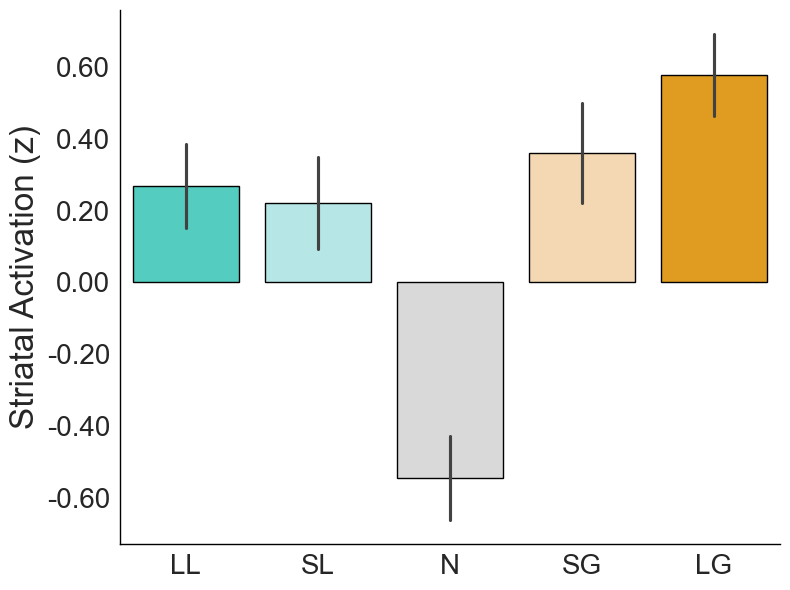

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Filter relevant columns
columns_of_interest = ['zstat_ACT_VS_LargeLoss', 'zstat_ACT_VS_SmallLoss', 'zstat_ACT_VS_Neut', 
                       'zstat_ACT_VS_SmallGain', 'zstat_ACT_VS_LargeGain']

# Reshape the data for seaborn plotting
df_melted = df[columns_of_interest].melt(var_name='Condition', value_name='Z-stat')

# Define condition order and labels
condition_order = ['zstat_ACT_VS_LargeLoss', 'zstat_ACT_VS_SmallLoss', 'zstat_ACT_VS_Neut', 
                   'zstat_ACT_VS_SmallGain', 'zstat_ACT_VS_LargeGain']
tick_labels = ['LL', 'SL', 'N', 'SG', 'LG']
gradient_palette = ["#40E0D0", "#AFEEEE", "#D9D9D9", "#FFD8A8", "#FFA500"]

# Create bar plot
g = sns.barplot(
    x='Condition', y='Z-stat', data=df_melted, order=condition_order,
    palette=gradient_palette, errorbar='se'
)

# Apply linear scale and formatting
plt.gca().set_yticklabels([f'{x:.2f}' for x in plt.gca().get_yticks()], fontsize=20)
plt.xticks(range(5), tick_labels, fontsize=20)
plt.xlabel('', fontsize=24)
plt.ylabel('Striatal Activation (z)', fontsize=24)

# Add trendline
#means = df_melted.groupby('Condition')['Z-stat'].mean().reindex(condition_order)
#plt.plot(range(len(means)), means.values, color='blue', linewidth=2, marker='o')

# Additional formatting
for bar in g.patches:
    bar.set_edgecolor("black")
    bar.set_linewidth(1)
g.spines[['top', 'right']].set_visible(False)
g.spines[['left', 'bottom']].set_color("black")
g.spines[['left', 'bottom']].set_linewidth(1)

plt.tight_layout()
plt.savefig('group-Zstat.svg', format='svg')
plt.show()

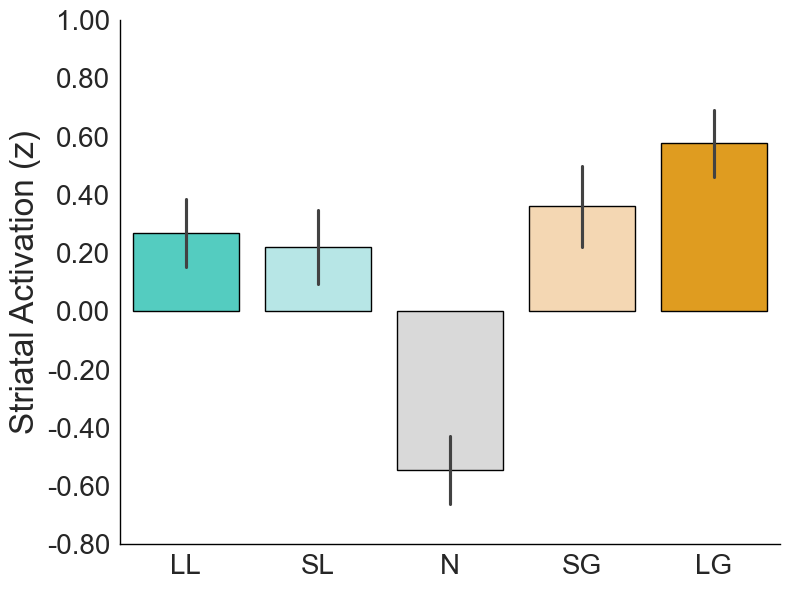

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Filter relevant columns
columns_of_interest = ['zstat_ACT_VS_LargeLoss', 'zstat_ACT_VS_SmallLoss', 'zstat_ACT_VS_Neut', 
                       'zstat_ACT_VS_SmallGain', 'zstat_ACT_VS_LargeGain']

# Reshape the data for seaborn plotting
df_melted = df[columns_of_interest].melt(var_name='Condition', value_name='Z-stat')

# Define condition order and labels
condition_order = ['zstat_ACT_VS_LargeLoss', 'zstat_ACT_VS_SmallLoss', 'zstat_ACT_VS_Neut', 
                   'zstat_ACT_VS_SmallGain', 'zstat_ACT_VS_LargeGain']
tick_labels = ['LL', 'SL', 'N', 'SG', 'LG']
gradient_palette = ["#40E0D0", "#AFEEEE", "#D9D9D9", "#FFD8A8", "#FFA500"]

# Create bar plot with SEM error bars
g = sns.barplot(
    x='Condition', y='Z-stat', data=df_melted, order=condition_order,
    palette=gradient_palette, errorbar='se'
)

# Calculate means and SEM for y-axis limits
means = df_melted.groupby('Condition')['Z-stat'].mean().reindex(condition_order)
sems = df_melted.groupby('Condition')['Z-stat'].sem().reindex(condition_order)
y_min = min(means - sems)
y_max = max(means + sems)
y_range = y_max - y_min

# Apply linear scale and formatting
plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
yticks = plt.gca().get_yticks()
plt.yticks(yticks, [f'{x:.2f}' for x in yticks], fontsize=20)
plt.xticks(range(5), tick_labels, fontsize=20)
plt.xlabel('', fontsize=24)
plt.ylabel('Striatal Activation (z)', fontsize=24)

# Add trendline (commented as in original)
#means = df_melted.groupby('Condition')['Z-stat'].mean().reindex(condition_order)
#plt.plot(range(len(means)), means.values, color='blue', linewidth=2, marker='o')

# Additional formatting
for bar in g.patches:
    bar.set_edgecolor("black")
    bar.set_linewidth(1)
g.spines[['top', 'right']].set_visible(False)
g.spines[['left', 'bottom']].set_color("black")
g.spines[['left', 'bottom']].set_linewidth(1)

plt.tight_layout()
plt.savefig('group-Zstat.svg', format='svg')
plt.show()

Created V_beta_new_splitthree successfully.

low group size before regression: 15
Added regression line for low

medium group size before regression: 15
Added regression line for medium

high group size before regression: 16
Added regression line for high


/var/folders/m6/p7f91dqd37d_mdjnjbx6xdy80000gn/T/ipykernel_30914/4264195740.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), fontsize=12)
/var/folders/m6/p7f91dqd37d_mdjnjbx6xdy80000gn/T/ipykernel_30914/4264195740.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels([f'{x:.2f}' for x in g.get_yticks()], fontsize=12)


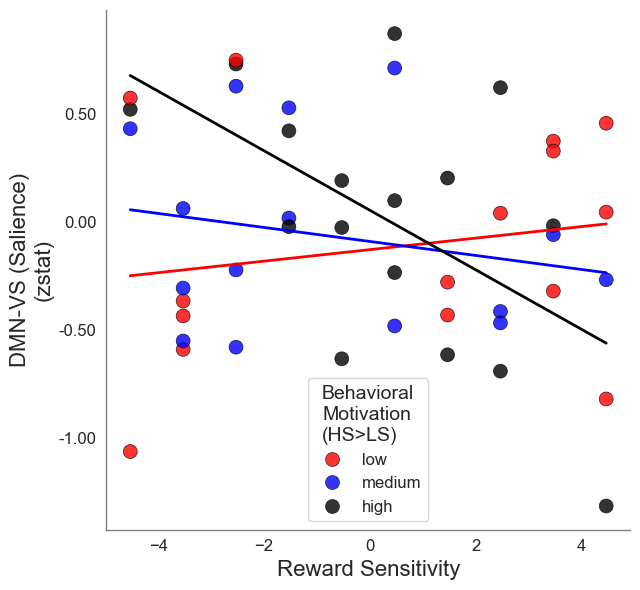


Linear Model Summary:
                              OLS Regression Results                             
Dep. Variable:     zstat_DMN_VS_Salience   R-squared:                       0.159
Model:                               OLS   Adj. R-squared:                  0.077
Method:                    Least Squares   F-statistic:                     1.933
Date:                   Sun, 04 May 2025   Prob (F-statistic):              0.123
Time:                           15:27:02   Log-Likelihood:                -30.734
No. Observations:                     46   AIC:                             71.47
Df Residuals:                         41   BIC:                             80.61
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Set seaborn style to mimic ggplot2's minimal theme
sns.set_style("white", {"axes.linecolor": "gray", "axes.edgecolor": "gray"})

# Load the data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Drop rows with missing required variables
df_plot = df[['comp_RS', 'zstat_DMN_VS_Salience', 'score_teps_ant', 'V_beta_new']].dropna().copy()

if df_plot.empty:
    print("Error: No valid data after dropping missing values. Cannot create plot.")
else:
    # Create V_beta_new_splitthree if not present
    if 'V_beta_new_splitthree' not in df_plot.columns:
        if df_plot['V_beta_new'].isna().all():
            print("Error: 'V_beta_new' contains all NaN. Cannot create V_beta_new_splitthree.")
            df_plot['V_beta_new_splitthree'] = 'All'
        else:
            try:
                df_plot['V_beta_new_splitthree'] = pd.qcut(df_plot['V_beta_new'], 3, labels=['low', 'medium', 'high'])
                print("Created V_beta_new_splitthree successfully.")
            except ValueError as e:
                print(f"Error creating V_beta_new_splitthree: {e}. Using single group.")
                df_plot['V_beta_new_splitthree'] = 'All'

    # Create scatterplot
    plt.figure(figsize=(6.5, 6))
    g = sns.scatterplot(
        x='comp_RS', y='zstat_DMN_VS_Salience', hue='V_beta_new_splitthree',
        data=df_plot, palette={'low': 'red', 'medium': 'blue', 'high': 'black'},
        s=100, alpha=0.8, edgecolor='black', linewidth=0.5
    )

    # Add regression lines without confidence intervals
    for group in ['low', 'medium', 'high']:
        group_df = df_plot[df_plot['V_beta_new_splitthree'] == group]
        print(f"\n{group} group size before regression: {len(group_df)}")
        if len(group_df) >= 2:
            try:
                sns.regplot(
                    x='comp_RS', y='zstat_DMN_VS_Salience', data=group_df,
                    scatter=False, color={'low': 'red', 'medium': 'blue', 'high': 'black'}[group],
                    line_kws={'linestyle': 'solid', 'linewidth': 2},
                    ci=None, ax=g
                )
                print(f"Added regression line for {group}")
            except Exception as e:
                print(f"Error adding regression line for {group}: {e}")
        else:
            print(f"Warning: Insufficient data for {group} regression line (n={len(group_df)}).")

    # Formatting
    plt.xlabel('Reward Sensitivity', fontsize=16)
    plt.ylabel('DMN-VS (Salience)\n(zstat)', fontsize=16)
    g.legend(title='Behavioral\nMotivation\n(HS>LS)', fontsize=12, title_fontsize=14, loc='best')
    g.set_xticklabels(g.get_xticklabels(), fontsize=12)
    g.set_yticklabels([f'{x:.2f}' for x in g.get_yticks()], fontsize=12)

    # Remove grid and set minimal theme
    g.grid(False)
    g.spines[['top', 'right']].set_visible(False)
    g.spines[['left', 'bottom']].set_color('gray')
    g.spines[['left', 'bottom']].set_linewidth(1)
    g.set_facecolor('white')

    plt.tight_layout()
    plt.savefig('dmn_vs_salience_scatter.svg', format='svg')
    plt.show()

# Run linear model
print("\nLinear Model Summary:")
model = smf.ols('zstat_DMN_VS_Salience ~ score_teps_ant + comp_RS * V_beta_new', data=df).fit()
print(model.summary())

Created V_beta_new_split successfully.


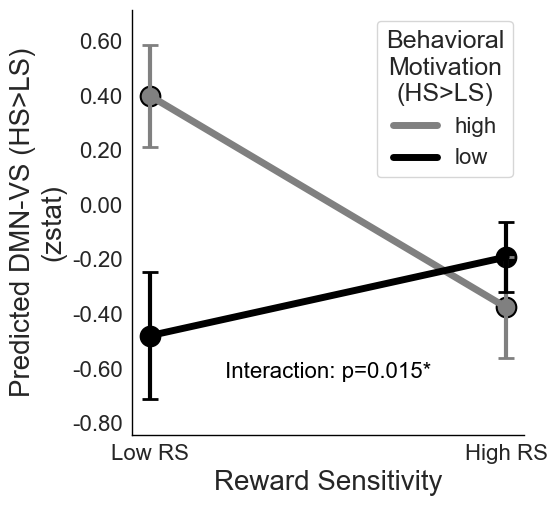


Linear Model Summary:
                              OLS Regression Results                             
Dep. Variable:     zstat_DMN_VS_Salience   R-squared:                       0.159
Model:                               OLS   Adj. R-squared:                  0.077
Method:                    Least Squares   F-statistic:                     1.933
Date:                   Sun, 04 May 2025   Prob (F-statistic):              0.123
Time:                           16:23:57   Log-Likelihood:                -30.734
No. Observations:                     46   AIC:                             71.47
Df Residuals:                         41   BIC:                             80.61
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np

# Set seaborn style
sns.set_style("white", {"axes.linecolor": "black", "axes.edgecolor": "black"})

# Load data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Drop missing values
df_plot = df[['comp_RS', 'zstat_DMN_VS_Salience', 'score_teps_ant', 'V_beta_new']].dropna().copy()

if df_plot.empty:
    print("Error: No valid data after dropping missing values. Cannot create plot.")
else:
    # Create V_beta_new_split
    if 'V_beta_new_split' not in df_plot.columns or df_plot['V_beta_new'].isna().all():
        print("Warning: 'V_beta_new_split' missing or 'V_beta_new' all NaN. Creating split.")
        try:
            df_plot['V_beta_new_split'] = pd.qcut(df_plot['V_beta_new'], 2, labels=['low', 'high'])
            print("Created V_beta_new_split successfully.")
        except ValueError as e:
            print(f"Error creating V_beta_new_split: {e}. Using single group.")
            df_plot['V_beta_new_split'] = 'All'
    else:
        df_plot['V_beta_new_split'] = df_plot['V_beta_new_split'].astype(str).str.lower()

    # Fit linear model
    model = smf.ols('zstat_DMN_VS_Salience ~ score_teps_ant + comp_RS * V_beta_new', data=df_plot).fit()

    # Create prediction data
    levels = sorted(df_plot['V_beta_new_split'].unique())
    comp_RS_low, comp_RS_high = np.percentile(df_plot['comp_RS'], [10, 90])
    score_teps_ant_mean = df_plot['score_teps_ant'].mean()
    pred_data = pd.DataFrame({
        'comp_RS': [comp_RS_low, comp_RS_high] * len(levels),
        'V_beta_new': [df_plot[df_plot['V_beta_new_split'] == level]['V_beta_new'].mean() for level in levels for _ in range(2)],
        'score_teps_ant': [score_teps_ant_mean] * (2 * len(levels)),
        'V_beta_new_split': [level for level in levels for _ in range(2)]
    })

    # Predict zstat_DMN_VS_Salience with SEM
    pred_result = model.get_prediction(pred_data)
    pred_summary = pred_result.summary_frame()
    pred_data['predicted'] = pred_summary['mean']
    pred_data['std_err'] = pred_summary['mean_se']

    # Plot interaction
    plt.figure(figsize=(5.5, 5))
    palette = {'low': 'black', 'high': 'gray'}
    for group in levels:
        group_data = pred_data[pred_data['V_beta_new_split'] == group]
        linestyle = 'solid'# if group == 'low' else '--'
        plt.plot(
            group_data['comp_RS'], group_data['predicted'],
            color=palette[group], linestyle=linestyle, linewidth=5, label=group
        )
        plt.errorbar(
            group_data['comp_RS'], group_data['predicted'],
            yerr=group_data['std_err'],
            color=palette[group], linewidth=3, capsize=6, capthick=2, fmt='none'
        )
        plt.scatter(
            group_data['comp_RS'], group_data['predicted'],
            color=palette[group], s=200, edgecolor='black', linewidth=1.5
        )

    # Add interaction p-value annotation
    p_value = model.pvalues['comp_RS:V_beta_new']
    y_min = min(pred_data['predicted'] - pred_data['std_err'])
    y_max = max(pred_data['predicted'] + pred_data['std_err'])
    y_range = y_max - y_min
    plt.text(
        (comp_RS_low + comp_RS_high) / 2, y_min + 0.05 * y_range,
        f'Interaction: p={p_value:.3f}{"*" if p_value < 0.05 else ""}',
        fontsize=16, ha='center', va='bottom', color='black'
    )

    # Formatting
    plt.xlabel('Reward Sensitivity', fontsize=20)
    plt.ylabel('Predicted DMN-VS (HS>LS)\n(zstat)', fontsize=20)
    plt.xticks([comp_RS_low, comp_RS_high], ['Low RS', 'High RS'], fontsize=16)
    yticks = plt.gca().get_yticks()
    plt.yticks(yticks, [f'{x:.2f}' for x in yticks], fontsize=16)
    leg = plt.legend(
        title='Behavioral\nMotivation\n(HS>LS)', fontsize=16, title_fontsize=18,
        loc='best'
    )
    leg.get_title().set_ha('center')
    plt.xlim(comp_RS_low - 0.05 * (comp_RS_high - comp_RS_low), comp_RS_high + 0.05 * (comp_RS_high - comp_RS_low))
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.gca().spines[['left', 'bottom']].set_color('black')
    plt.gca().spines[['left', 'bottom']].set_linewidth(1)
    plt.gca().set_facecolor('white')
    plt.grid(False)

    plt.tight_layout(pad=0.5)
    plt.savefig('interaction_plot_comp_rs_v_beta_new_sem.svg', format='svg')
    plt.show()

    # Linear model summary
    print("\nLinear Model Summary:")
    print(model.summary())

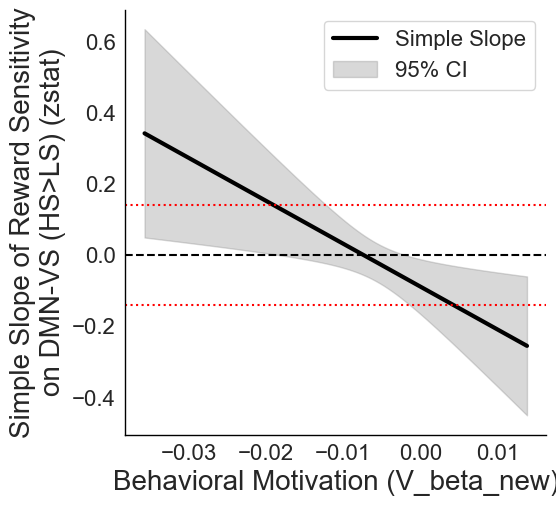


Linear Model Summary:
                              OLS Regression Results                             
Dep. Variable:     zstat_DMN_VS_Salience   R-squared:                       0.159
Model:                               OLS   Adj. R-squared:                  0.077
Method:                    Least Squares   F-statistic:                     1.933
Date:                   Thu, 15 May 2025   Prob (F-statistic):              0.123
Time:                           13:41:40   Log-Likelihood:                -30.734
No. Observations:                     46   AIC:                             71.47
Df Residuals:                         41   BIC:                             80.61
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
from scipy import stats

# Set seaborn style
sns.set_style("white", {"axes.linecolor": "black", "axes.edgecolor": "black"})

# Load data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Drop missing values
df_plot = df[['comp_RS', 'zstat_DMN_VS_Salience', 'score_teps_ant', 'V_beta_new']].dropna().copy()

if df_plot.empty:
    print("Error: No valid data after dropping missing values. Cannot create plot.")
else:
    # Fit linear model
    model = smf.ols('zstat_DMN_VS_Salience ~ score_teps_ant + comp_RS * V_beta_new', data=df_plot).fit()

    # Extract model parameters
    params = model.params
    cov_matrix = model.cov_params()
    
    # Define range of V_beta_new values
    v_beta_range = np.linspace(df_plot['V_beta_new'].min(), df_plot['V_beta_new'].max(), 100)
    
    # Calculate simple slopes and standard errors
    slopes = []
    se_slopes = []
    for v in v_beta_range:
        # Simple slope of comp_RS at V_beta_new = v
        slope = params['comp_RS'] + params['comp_RS:V_beta_new'] * v
        
        # Variance of the slope
        var_slope = (
            cov_matrix.loc['comp_RS', 'comp_RS'] +
            v**2 * cov_matrix.loc['comp_RS:V_beta_new', 'comp_RS:V_beta_new'] +
            2 * v * cov_matrix.loc['comp_RS', 'comp_RS:V_beta_new']
        )
        se_slope = np.sqrt(var_slope)
        
        slopes.append(slope)
        se_slopes.append(se_slope)
    
    slopes = np.array(slopes)
    se_slopes = np.array(se_slopes)
    
    # Calculate confidence intervals (95%)
    ci_lower = slopes - stats.t.ppf(0.975, model.df_resid) * se_slopes
    ci_upper = slopes + stats.t.ppf(0.975, model.df_resid) * se_slopes
    
    # Identify regions of significance (where CI does not include 0)
    sig_region = (ci_lower > 0) | (ci_upper < 0)
    
    # Create J-N plot
    plt.figure(figsize=(5.5, 5))
    
    # Plot the simple slope
    plt.plot(v_beta_range, slopes, color='black', linewidth=3, label='Simple Slope')
    
    # Plot confidence bands
    plt.fill_between(
        v_beta_range, ci_lower, ci_upper,
        color='gray', alpha=0.3, label='95% CI'
    )
    
    # Add horizontal line at slope = 0
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
    
    # Add significance threshold lines (t-critical * SE)
    t_crit = stats.t.ppf(0.975, model.df_resid)
    plt.axhline(y=t_crit * se_slopes.mean(), color='red', linestyle=':', linewidth=1.5)
    plt.axhline(y=-t_crit * se_slopes.mean(), color='red', linestyle=':', linewidth=1.5)
    
    # Formatting
    plt.xlabel('Behavioral Motivation (V_beta_new)', fontsize=20)
    plt.ylabel('Simple Slope of Reward Sensitivity\non DMN-VS (HS>LS) (zstat)', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16, loc='best')
    plt.xlim(v_beta_range.min() - 0.05 * (v_beta_range.max() - v_beta_range.min()),
             v_beta_range.max() + 0.05 * (v_beta_range.max() - v_beta_range.min()))
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.gca().spines[['left', 'bottom']].set_color('black')
    plt.gca().spines[['left', 'bottom']].set_linewidth(1)
    plt.gca().set_facecolor('white')
    plt.grid(False)
    
    plt.tight_layout(pad=0.5)
    plt.savefig('jn_plot_comp_rs_v_beta_new.svg', format='svg')
    plt.show()
    
    # Print linear model summary
    print("\nLinear Model Summary:")
    print(model.summary())
    
    # Print regions of significance
    print("\nJohnson-Neyman Analysis:")
    sig_points = v_beta_range[sig_region]
    if len(sig_points) > 0:
        print(f"Regions of significance (p < 0.05) for V_beta_new: {sig_points.min():.3f} to {sig_points.max():.3f}")
    else:
        print("No regions of significance found (p >= 0.05 for all V_beta_new values).")

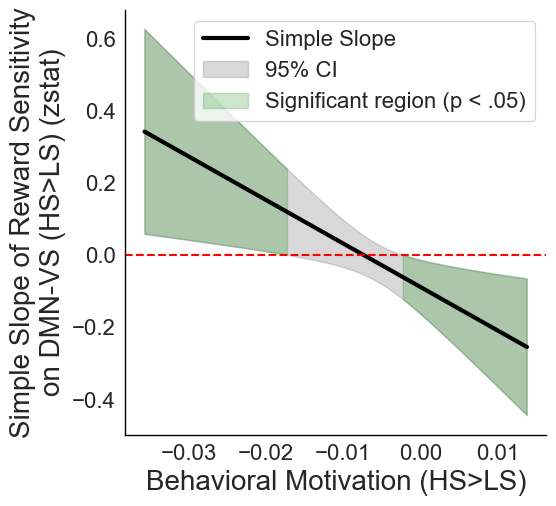


Linear Model Summary:
                              OLS Regression Results                             
Dep. Variable:     zstat_DMN_VS_Salience   R-squared:                       0.159
Model:                               OLS   Adj. R-squared:                  0.077
Method:                    Least Squares   F-statistic:                     1.933
Date:                   Thu, 15 May 2025   Prob (F-statistic):              0.123
Time:                           13:55:41   Log-Likelihood:                -30.734
No. Observations:                     46   AIC:                             71.47
Df Residuals:                         41   BIC:                             80.61
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
from scipy.stats import norm

# Set seaborn style
sns.set_style("white", {"axes.linecolor": "black", "axes.edgecolor": "black"})

# Load data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Drop missing values
df_plot = df[['comp_RS', 'zstat_DMN_VS_Salience', 'score_teps_ant', 'V_beta_new']].dropna().copy()

if df_plot.empty:
    print("Error: No valid data after dropping missing values. Cannot create plot.")
else:
    # Fit linear model
    model = smf.ols('zstat_DMN_VS_Salience ~ score_teps_ant + comp_RS * V_beta_new', data=df_plot).fit()

    # Extract model parameters
    params = model.params
    cov_matrix = model.cov_params()
    
    # Define range of V_beta_new values
    v_beta_range = np.linspace(df_plot['V_beta_new'].min(), df_plot['V_beta_new'].max(), 100)
    
    # Calculate simple slopes, standard errors, and p-values
    slopes = []
    se_slopes = []
    pvals = []
    
    for v in v_beta_range:
        # Simple slope of comp_RS at V_beta_new = v
        slope = params['comp_RS'] + params['comp_RS:V_beta_new'] * v
        
        # Variance of the slope
        var_slope = (
            cov_matrix.loc['comp_RS', 'comp_RS'] +
            v**2 * cov_matrix.loc['comp_RS:V_beta_new', 'comp_RS:V_beta_new'] +
            2 * v * cov_matrix.loc['comp_RS', 'comp_RS:V_beta_new']
        )
        se_slope = np.sqrt(var_slope)
        
        # Compute p-value for test of slope = 0
        tval = slope / se_slope
        pval = 2 * (1 - norm.cdf(np.abs(tval)))
        
        slopes.append(slope)
        se_slopes.append(se_slope)
        pvals.append(pval)
    
    slopes = np.array(slopes)
    se_slopes = np.array(se_slopes)
    pvals = np.array(pvals)
    
    # Calculate confidence intervals (95%)
    ci_lower = slopes - 1.96 * se_slopes
    ci_upper = slopes + 1.96 * se_slopes
    
    # Create J-N plot
    plt.figure(figsize=(5.5, 5))
    
    # Plot the simple slope
    plt.plot(v_beta_range, slopes, color='black', linewidth=3, label='Simple Slope')
    
    # Plot confidence bands
    plt.fill_between(
        v_beta_range, ci_lower, ci_upper,
        color='gray', alpha=0.3, label='95% CI'
    )
    
    # Highlight significant regions (p < 0.05)
    plt.fill_between(
        v_beta_range, ci_lower, ci_upper,
        where=(pvals < 0.05), color='green', alpha=0.2, label='Significant region (p < .05)'
    )
    
    # Add horizontal line at slope = 0
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
    
    # Formatting
    plt.xlabel('Behavioral Motivation (HS>LS)', fontsize=20)
    plt.ylabel('Simple Slope of Reward Sensitivity\non DMN-VS (HS>LS) (zstat)', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16, loc='best')
    plt.xlim(v_beta_range.min() - 0.05 * (v_beta_range.max() - v_beta_range.min()),
             v_beta_range.max() + 0.05 * (v_beta_range.max() - v_beta_range.min()))
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.gca().spines[['left', 'bottom']].set_color('black')
    plt.gca().spines[['left', 'bottom']].set_linewidth(1)
    plt.gca().set_facecolor('white')
    plt.grid(False)
    
    plt.tight_layout(pad=0.5)
    plt.savefig('jn_plot_comp_rs_v_beta_new.svg', format='svg')
    plt.show()
    
    # Print linear model summary
    print("\nLinear Model Summary:")
    print(model.summary())
    
    # Print regions of significance
    print("\nJohnson-Neyman Analysis:")
    sig_points = v_beta_range[pvals < 0.05]
    if len(sig_points) > 0:
        print(f"Regions of significance (p < 0.05) for V_beta_new: {sig_points.min():.3f} to {sig_points.max():.3f}")
    else:
        print("No regions of significance found (p >= 0.05 for all V_beta_new values).")

### At low levels of Behavioral Motivation (HS>LS; <-.02):
- The slope of Reward Sensitivity --> DMN-VS Connectivity is positive and significant.
- Interpretation: Among people with lower behavioral motivation (i.e., weaker reaction time differences for high vs. low stakes), greater reward sensitivity predicts greater DMN-VS connectivity.

### At moderate levels of Behavioral Motivation (HS>LS; -.02 to ~0):
- The slope is not statistically different from zero.
- Interpretation: Among people with average levels of behavioral motivation, reward sensitivity does not significantly predict DMN-VS connectivity.

### At high levels of Behavioral Motivation (HS>LS; >0):
- The slope is negative and significant.
- Interpretation: Among people with higher behavioral motivation, greater reward sensitivity predicts lesser DMN-VS connectivity.

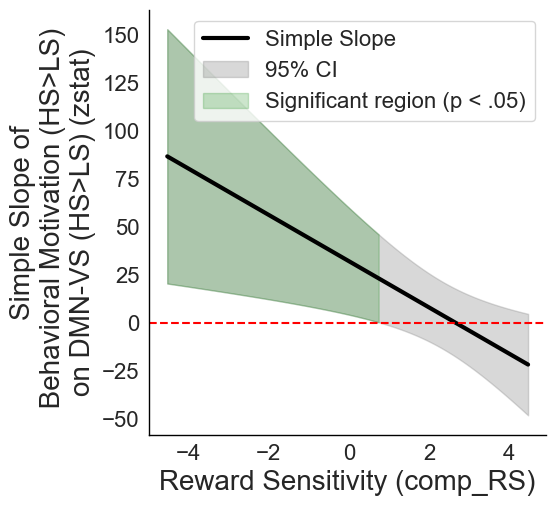


Linear Model Summary:
                              OLS Regression Results                             
Dep. Variable:     zstat_DMN_VS_Salience   R-squared:                       0.159
Model:                               OLS   Adj. R-squared:                  0.077
Method:                    Least Squares   F-statistic:                     1.933
Date:                   Thu, 15 May 2025   Prob (F-statistic):              0.123
Time:                           18:58:06   Log-Likelihood:                -30.734
No. Observations:                     46   AIC:                             71.47
Df Residuals:                         41   BIC:                             80.61
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
from scipy.stats import norm

# Set seaborn style
sns.set_style("white", {"axes.linecolor": "black", "axes.edgecolor": "black"})

# Load data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Drop missing values
df_plot = df[['comp_RS', 'zstat_DMN_VS_Salience', 'score_teps_ant', 'V_beta_new']].dropna().copy()

if df_plot.empty:
    print("Error: No valid data after dropping missing values. Cannot create plot.")
else:
    # Fit linear model
    model = smf.ols('zstat_DMN_VS_Salience ~ score_teps_ant + comp_RS * V_beta_new', data=df_plot).fit()

    # Extract model parameters and covariance matrix
    params = model.params
    cov = model.cov_params()

    # Define range of comp_RS values
    rs_range = np.linspace(df_plot['comp_RS'].min(), df_plot['comp_RS'].max(), 100)

    # Calculate simple slopes, standard errors, and p-values
    slopes = []
    se_slopes = []
    pvals = []

    for value in rs_range:
        # Simple slope of V_beta_new at comp_RS = value
        slope = params['V_beta_new'] + params['comp_RS:V_beta_new'] * value

        # Compute standard error of the simple slope
        se = np.sqrt(
            cov.loc['V_beta_new', 'V_beta_new'] +
            2 * value * cov.loc['V_beta_new', 'comp_RS:V_beta_new'] +
            value ** 2 * cov.loc['comp_RS:V_beta_new', 'comp_RS:V_beta_new']
        )
        se_slopes.append(se)

        # Compute p-value for test of slope = 0
        tval = slope / se
        pval = 2 * (1 - norm.cdf(np.abs(tval)))
        pvals.append(pval)

        slopes.append(slope)

    slopes = np.array(slopes)
    se_slopes = np.array(se_slopes)
    pvals = np.array(pvals)

    # Calculate confidence intervals (95%)
    ci_lower = slopes - 1.96 * se_slopes
    ci_upper = slopes + 1.96 * se_slopes

    # Create J-N plot
    plt.figure(figsize=(5.5, 5))
    plt.plot(rs_range, slopes, color='black', linewidth=3, label='Simple Slope')
    plt.fill_between(rs_range, ci_lower, ci_upper, color='gray', alpha=0.3, label='95% CI')

    # Highlight significant regions (p < 0.05)
    plt.fill_between(
        rs_range, ci_lower, ci_upper,
        where=(pvals < 0.05), color='green', alpha=0.2, label='Significant region (p < .05)'
    )

    # Add horizontal line at slope = 0
    plt.axhline(0, color='red', linestyle='--', linewidth=1.5)

    # Formatting
    plt.xlabel('Reward Sensitivity (comp_RS)', fontsize=20)
    plt.ylabel('Simple Slope of\n Behavioral Motivation (HS>LS)\non DMN-VS (HS>LS) (zstat)', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16, loc='best')
    plt.xlim(rs_range.min() - 0.05 * (rs_range.max() - rs_range.min()),
             rs_range.max() + 0.05 * (rs_range.max() - rs_range.min()))
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.gca().spines[['left', 'bottom']].set_color('black')
    plt.gca().spines[['left', 'bottom']].set_linewidth(1)
    plt.gca().set_facecolor('white')
    plt.grid(False)

    plt.tight_layout(pad=0.5)
    plt.savefig('jn_plot_v_beta_new_comp_rs.svg', format='svg')
    plt.show()

    # Print linear model summary
    print("\nLinear Model Summary:")
    print(model.summary())

    # Print regions of significance
    print("\nJohnson-Neyman Analysis:")
    sig_points = rs_range[pvals < 0.05]
    if len(sig_points) > 0:
        print(f"Regions of significance (p < 0.05) for comp_RS: {sig_points.min():.3f} to {sig_points.max():.3f}")
    else:
        print("No regions of significance found (p >= 0.05 for all comp_RS values).")

Created LG_N_new_split successfully.


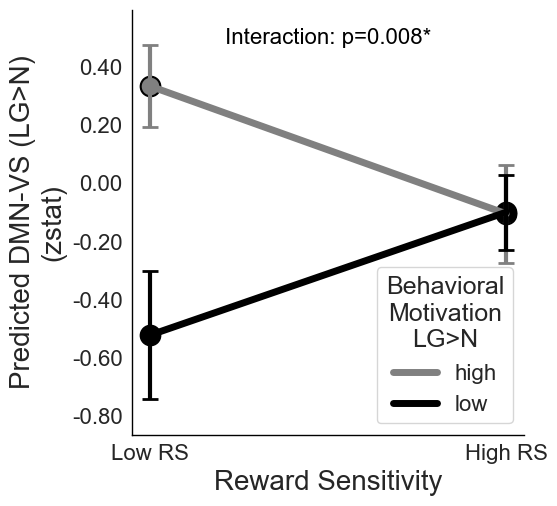


Linear Model Summary:
                               OLS Regression Results                              
Dep. Variable:     zstat_DMN_VS_LG_minus_N   R-squared:                       0.243
Model:                                 OLS   Adj. R-squared:                  0.169
Method:                      Least Squares   F-statistic:                     3.282
Date:                     Sun, 04 May 2025   Prob (F-statistic):             0.0201
Time:                             16:22:09   Log-Likelihood:                -32.217
No. Observations:                       46   AIC:                             74.43
Df Residuals:                           41   BIC:                             83.58
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np

# Set seaborn style
sns.set_style("white", {"axes.linecolor": "black", "axes.edgecolor": "black"})

# Load data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Drop missing values
df_plot = df[['comp_RS', 'zstat_DMN_VS_LG_minus_N', 'score_teps_ant', 'LG_N_new']].dropna().copy()

if df_plot.empty:
    print("Error: No valid data after dropping missing values. Cannot create plot.")
else:
    # Create LG_N_new_split
    if 'LG_N_new_split' not in df_plot.columns or df_plot['LG_N_new'].isna().all():
        print("Warning: 'LG_N_new_split' missing or 'LG_N_new' all NaN. Creating split.")
        try:
            df_plot['LG_N_new_split'] = pd.qcut(df_plot['LG_N_new'], 2, labels=['low', 'high'])
            print("Created LG_N_new_split successfully.")
        except ValueError as e:
            print(f"Error creating LG_N_new_split: {e}. Using single group.")
            df_plot['LG_N_new_split'] = 'All'
    else:
        df_plot['LG_N_new_split'] = df_plot['LG_N_new_split'].astype(str).str.lower()

    # Fit linear model
    model = smf.ols('zstat_DMN_VS_LG_minus_N ~ score_teps_ant + comp_RS * LG_N_new', data=df_plot).fit()

    # Create prediction data
    levels = sorted(df_plot['LG_N_new_split'].unique())
    comp_RS_low, comp_RS_high = np.percentile(df_plot['comp_RS'], [10, 90])
    score_teps_ant_mean = df_plot['score_teps_ant'].mean()
    pred_data = pd.DataFrame({
        'comp_RS': [comp_RS_low, comp_RS_high] * len(levels),
        'LG_N_new': [df_plot[df_plot['LG_N_new_split'] == level]['LG_N_new'].mean() for level in levels for _ in range(2)],
        'score_teps_ant': [score_teps_ant_mean] * (2 * len(levels)),
        'LG_N_new_split': [level for level in levels for _ in range(2)]
    })

    # Predict zstat_DMN_VS_LG_minus_N with SEM
    pred_result = model.get_prediction(pred_data)
    pred_summary = pred_result.summary_frame()
    pred_data['predicted'] = pred_summary['mean']
    pred_data['std_err'] = pred_summary['mean_se']

    # Plot interaction
    plt.figure(figsize=(5.5, 5))
    palette = {'low': 'black', 'high': 'gray'}
    for group in levels:
        group_data = pred_data[pred_data['LG_N_new_split'] == group]
        linestyle = 'solid'# if group == 'low' else '--'
        plt.plot(
            group_data['comp_RS'], group_data['predicted'],
            color=palette[group], linestyle=linestyle, linewidth=5, label=group
        )
        plt.errorbar(
            group_data['comp_RS'], group_data['predicted'],
            yerr=group_data['std_err'],
            color=palette[group], linewidth=3, capsize=6, capthick=2, fmt='none'
        )
        plt.scatter(
            group_data['comp_RS'], group_data['predicted'],
            color=palette[group], s=200, edgecolor='black', linewidth=1.5
        )

    # Add interaction p-value annotation at top
    p_value = model.pvalues['comp_RS:LG_N_new']
    y_min = min(pred_data['predicted'] - pred_data['std_err'])
    y_max = max(pred_data['predicted'] + pred_data['std_err'])
    y_range = y_max - y_min
    plt.text(
        (comp_RS_low + comp_RS_high) / 2, y_max + 0.05 * y_range,
        f'Interaction: p={p_value:.3f}{"*" if p_value < 0.05 else ""}',
        fontsize=16, ha='center', va='top', color='black'
    )

    # Formatting
    plt.xlabel('Reward Sensitivity', fontsize=20)
    plt.ylabel('Predicted DMN-VS (LG>N)\n(zstat)', fontsize=20)
    plt.xticks([comp_RS_low, comp_RS_high], ['Low RS', 'High RS'], fontsize=16)
    yticks = plt.gca().get_yticks()
    plt.yticks(yticks, [f'{x:.2f}' for x in yticks], fontsize=16)
    leg = plt.legend(
        title='Behavioral\nMotivation\nLG>N', fontsize=16, title_fontsize=18,
        loc='best'
    )
    leg.get_title().set_ha('center')
    plt.xlim(comp_RS_low - 0.05 * (comp_RS_high - comp_RS_low), comp_RS_high + 0.05 * (comp_RS_high - comp_RS_low))
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.gca().spines[['left', 'bottom']].set_color('black')
    plt.gca().spines[['left', 'bottom']].set_linewidth(1)
    plt.gca().set_facecolor('white')
    plt.grid(False)

    plt.tight_layout(pad=0.5)
    plt.savefig('interaction_plot_comp_rs_lg_n_new_sem.svg', format='svg')
    plt.show()

    # Linear model summary
    print("\nLinear Model Summary:")
    print(model.summary())

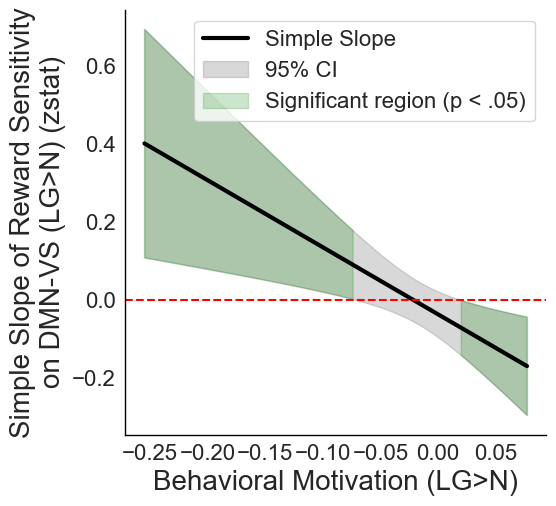


Linear Model Summary:
                               OLS Regression Results                              
Dep. Variable:     zstat_DMN_VS_LG_minus_N   R-squared:                       0.243
Model:                                 OLS   Adj. R-squared:                  0.169
Method:                      Least Squares   F-statistic:                     3.282
Date:                     Thu, 15 May 2025   Prob (F-statistic):             0.0201
Time:                             16:32:12   Log-Likelihood:                -32.217
No. Observations:                       46   AIC:                             74.43
Df Residuals:                           41   BIC:                             83.58
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
from scipy.stats import norm

# Set seaborn style
sns.set_style("white", {"axes.linecolor": "black", "axes.edgecolor": "black"})

# Load data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Drop missing values
df_plot = df[['comp_RS', 'zstat_DMN_VS_LG_minus_N', 'score_teps_ant', 'LG_N_new']].dropna().copy()

if df_plot.empty:
    print("Error: No valid data after dropping missing values. Cannot create plot.")
else:
    # Fit linear model
    model = smf.ols('zstat_DMN_VS_LG_minus_N ~ score_teps_ant + comp_RS * LG_N_new', data=df_plot).fit()

    # Extract model parameters and covariance matrix
    params = model.params
    cov = model.cov_params()

    # Define range of LG_N_new values
    lg_n_range = np.linspace(df_plot['LG_N_new'].min(), df_plot['LG_N_new'].max(), 100)

    # Calculate simple slopes, standard errors, and p-values
    simple_slopes = []
    se_slopes = []
    pvals = []

    for value in lg_n_range:
        # Simple slope of comp_RS at LG_N_new = value
        slope = params['comp_RS'] + params['comp_RS:LG_N_new'] * value

        # Compute standard error of the simple slope
        se = np.sqrt(
            cov.loc['comp_RS', 'comp_RS'] +
            2 * value * cov.loc['comp_RS', 'comp_RS:LG_N_new'] +
            value ** 2 * cov.loc['comp_RS:LG_N_new', 'comp_RS:LG_N_new']
        )
        se_slopes.append(se)

        # Compute p-value for test of slope = 0
        tval = slope / se
        pval = 2 * (1 - norm.cdf(np.abs(tval)))
        pvals.append(pval)

        simple_slopes.append(slope)

    simple_slopes = np.array(simple_slopes)
    se_slopes = np.array(se_slopes)
    pvals = np.array(pvals)

    # Calculate confidence intervals (95%)
    ci_lower = simple_slopes - 1.96 * se_slopes
    ci_upper = simple_slopes + 1.96 * se_slopes

    # Create J-N plot
    plt.figure(figsize=(5.5, 5))
    plt.plot(lg_n_range, simple_slopes, color='black', linewidth=3, label='Simple Slope')
    plt.fill_between(lg_n_range, ci_lower, ci_upper, color='gray', alpha=0.3, label='95% CI')

    # Highlight significant regions (p < 0.05)
    plt.fill_between(
        lg_n_range, ci_lower, ci_upper,
        where=(pvals < 0.05), color='green', alpha=0.2, label='Significant region (p < .05)'
    )

    # Add horizontal line at slope = 0
    plt.axhline(0, color='red', linestyle='--', linewidth=1.5)

    # Formatting
    plt.xlabel('Behavioral Motivation (LG>N)', fontsize=20)
    plt.ylabel('Simple Slope of Reward Sensitivity\non DMN-VS (LG>N) (zstat)', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16, loc='best')
    plt.xlim(lg_n_range.min() - 0.05 * (lg_n_range.max() - lg_n_range.min()),
             lg_n_range.max() + 0.05 * (lg_n_range.max() - lg_n_range.min()))
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.gca().spines[['left', 'bottom']].set_color('black')
    plt.gca().spines[['left', 'bottom']].set_linewidth(1)
    plt.gca().set_facecolor('white')
    plt.grid(False)

    plt.tight_layout(pad=0.5)
    plt.savefig('jn_plot_comp_rs_lg_n_new.svg', format='svg')
    plt.show()

    # Print linear model summary
    print("\nLinear Model Summary:")
    print(model.summary())

    # Print regions of significance
    print("\nJohnson-Neyman Analysis:")
    sig_points = lg_n_range[pvals < 0.05]
    if len(sig_points) > 0:
        print(f"Regions of significance (p < 0.05) for LG_N_new: {sig_points.min():.3f} to {sig_points.max():.3f}")
    else:
        print("No regions of significance found (p >= 0.05 for all LG_N_new values).")

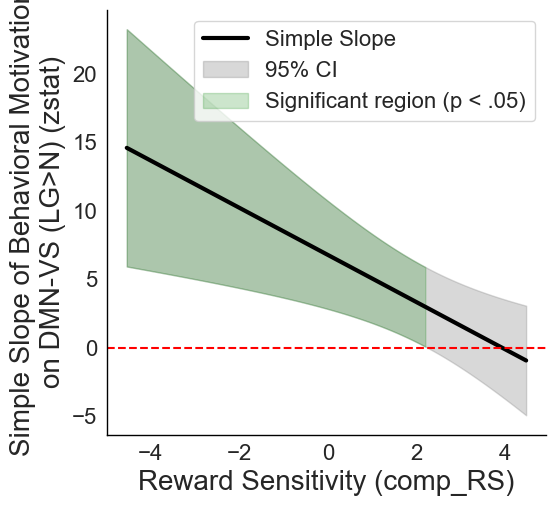


Linear Model Summary:
                               OLS Regression Results                              
Dep. Variable:     zstat_DMN_VS_LG_minus_N   R-squared:                       0.243
Model:                                 OLS   Adj. R-squared:                  0.169
Method:                      Least Squares   F-statistic:                     3.282
Date:                     Thu, 15 May 2025   Prob (F-statistic):             0.0201
Time:                             18:59:52   Log-Likelihood:                -32.217
No. Observations:                       46   AIC:                             74.43
Df Residuals:                           41   BIC:                             83.58
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
from scipy.stats import norm

# Set seaborn style
sns.set_style("white", {"axes.linecolor": "black", "axes.edgecolor": "black"})

# Load data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Drop missing values
df_plot = df[['comp_RS', 'zstat_DMN_VS_LG_minus_N', 'score_teps_ant', 'LG_N_new']].dropna().copy()

if df_plot.empty:
    print("Error: No valid data after dropping missing values. Cannot create plot.")
else:
    # Fit linear model
    model = smf.ols('zstat_DMN_VS_LG_minus_N ~ score_teps_ant + comp_RS * LG_N_new', data=df_plot).fit()

    # Extract model parameters and covariance matrix
    params = model.params
    cov = model.cov_params()

    # Define range of comp_RS values
    rs_range = np.linspace(df_plot['comp_RS'].min(), df_plot['comp_RS'].max(), 100)

    # Calculate simple slopes, standard errors, and p-values
    slopes = []
    se_slopes = []
    pvals = []

    for value in rs_range:
        # Simple slope of LG_N_new at comp_RS = value
        slope = params['LG_N_new'] + params['comp_RS:LG_N_new'] * value

        # Compute standard error of the simple slope
        se = np.sqrt(
            cov.loc['LG_N_new', 'LG_N_new'] +
            2 * value * cov.loc['LG_N_new', 'comp_RS:LG_N_new'] +
            value ** 2 * cov.loc['comp_RS:LG_N_new', 'comp_RS:LG_N_new']
        )
        se_slopes.append(se)

        # Compute p-value for test of slope = 0
        tval = slope / se
        pval = 2 * (1 - norm.cdf(np.abs(tval)))
        pvals.append(pval)

        slopes.append(slope)

    slopes = np.array(slopes)
    se_slopes = np.array(se_slopes)
    pvals = np.array(pvals)

    # Calculate confidence intervals (95%)
    ci_lower = slopes - 1.96 * se_slopes
    ci_upper = slopes + 1.96 * se_slopes

    # Create J-N plot
    plt.figure(figsize=(5.5, 5))
    plt.plot(rs_range, slopes, color='black', linewidth=3, label='Simple Slope')
    plt.fill_between(rs_range, ci_lower, ci_upper, color='gray', alpha=0.3, label='95% CI')

    # Highlight significant regions (p < 0.05)
    plt.fill_between(
        rs_range, ci_lower, ci_upper,
        where=(pvals < 0.05), color='green', alpha=0.2, label='Significant region (p < .05)'
    )

    # Add horizontal line at slope = 0
    plt.axhline(0, color='red', linestyle='--', linewidth=1.5)

    # Formatting
    plt.xlabel('Reward Sensitivity (comp_RS)', fontsize=20)
    plt.ylabel('Simple Slope of Behavioral Motivation\non DMN-VS (LG>N) (zstat)', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16, loc='best')
    plt.xlim(rs_range.min() - 0.05 * (rs_range.max() - rs_range.min()),
             rs_range.max() + 0.05 * (rs_range.max() - rs_range.min()))
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.gca().spines[['left', 'bottom']].set_color('black')
    plt.gca().spines[['left', 'bottom']].set_linewidth(1)
    plt.gca().set_facecolor('white')
    plt.grid(False)

    plt.tight_layout(pad=0.5)
    plt.savefig('jn_plot_comp_rs_lg_n_new.svg', format='svg')
    plt.show()

    # Print linear model summary
    print("\nLinear Model Summary:")
    print(model.summary())

    # Print regions of significance
    print("\nJohnson-Neyman Analysis:")
    sig_points = rs_range[pvals < 0.05]
    if len(sig_points) > 0:
        print(f"Regions of significance (p < 0.05) for comp_RS: {sig_points.min():.3f} to {sig_points.max():.3f}")
    else:
        print("No regions of significance found (p >= 0.05 for all comp_RS values).")

Created LL_N_new_split successfully.


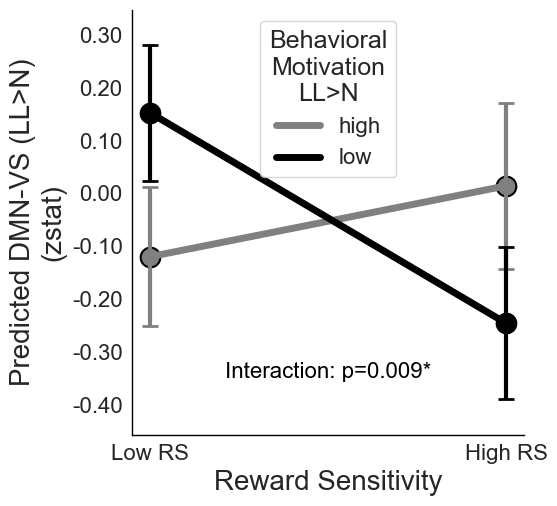


Linear Model Summary:
                               OLS Regression Results                              
Dep. Variable:     zstat_DMN_VS_LL_minus_N   R-squared:                       0.209
Model:                                 OLS   Adj. R-squared:                  0.132
Method:                      Least Squares   F-statistic:                     2.711
Date:                     Sun, 04 May 2025   Prob (F-statistic):             0.0430
Time:                             16:05:42   Log-Likelihood:                -30.847
No. Observations:                       46   AIC:                             71.69
Df Residuals:                           41   BIC:                             80.84
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np

# Set seaborn style
sns.set_style("white", {"axes.linecolor": "black", "axes.edgecolor": "black"})

# Load data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Drop missing values
df_plot = df[['comp_RS', 'zstat_DMN_VS_LL_minus_N', 'score_teps_ant', 'LL_N_new']].dropna().copy()

if df_plot.empty:
    print("Error: No valid data after dropping missing values. Cannot create plot.")
else:
    # Create LL_N_new_split
    if 'LL_N_new_split' not in df_plot.columns or df_plot['LL_N_new'].isna().all():
        print("Warning: 'LL_N_new_split' missing or 'LL_N_new' all NaN. Creating split.")
        try:
            df_plot['LL_N_new_split'] = pd.qcut(df_plot['LL_N_new'], 2, labels=['low', 'high'])
            print("Created LL_N_new_split successfully.")
        except ValueError as e:
            print(f"Error creating LL_N_new_split: {e}. Using single group.")
            df_plot['LL_N_new_split'] = 'All'
    else:
        df_plot['LL_N_new_split'] = df_plot['LL_N_new_split'].astype(str).str.lower()

    # Fit linear model
    model = smf.ols('zstat_DMN_VS_LL_minus_N ~ score_teps_ant + comp_RS * LL_N_new', data=df_plot).fit()

    # Create prediction data
    levels = sorted(df_plot['LL_N_new_split'].unique())
    comp_RS_low, comp_RS_high = np.percentile(df_plot['comp_RS'], [10, 90])
    score_teps_ant_mean = df_plot['score_teps_ant'].mean()
    pred_data = pd.DataFrame({
        'comp_RS': [comp_RS_low, comp_RS_high] * len(levels),
        'LL_N_new': [df_plot[df_plot['LL_N_new_split'] == level]['LL_N_new'].mean() for level in levels for _ in range(2)],
        'score_teps_ant': [score_teps_ant_mean] * (2 * len(levels)),
        'LL_N_new_split': [level for level in levels for _ in range(2)]
    })

    # Predict zstat_DMN_VS_LL_minus_N with SEM
    pred_result = model.get_prediction(pred_data)
    pred_summary = pred_result.summary_frame()
    pred_data['predicted'] = pred_summary['mean']
    pred_data['std_err'] = pred_summary['mean_se']

    # Plot interaction
    plt.figure(figsize=(5.5, 5))
    palette = {'low': 'black', 'high': 'gray'}
    for group in levels:
        group_data = pred_data[pred_data['LL_N_new_split'] == group]
        linestyle = 'solid'# if group == 'low' else '--'
        plt.plot(
            group_data['comp_RS'], group_data['predicted'],
            color=palette[group], linestyle=linestyle, linewidth=5, label=group
        )
        plt.errorbar(
            group_data['comp_RS'], group_data['predicted'],
            yerr=group_data['std_err'],
            color=palette[group], linewidth=3, capsize=6, capthick=2, fmt='none'
        )
        plt.scatter(
            group_data['comp_RS'], group_data['predicted'],
            color=palette[group], s=200, edgecolor='black', linewidth=1.5
        )

    # Add interaction p-value annotation
    p_value = model.pvalues['comp_RS:LL_N_new']
    y_min = min(pred_data['predicted'] - pred_data['std_err'])
    y_max = max(pred_data['predicted'] + pred_data['std_err'])
    y_range = y_max - y_min
    plt.text(
        (comp_RS_low + comp_RS_high) / 2, y_min + 0.05 * y_range,
        f'Interaction: p={p_value:.3f}{"*" if p_value < 0.05 else ""}',
        fontsize=16, ha='center', va='bottom', color='black'
    )

    # Formatting
    plt.xlabel('Reward Sensitivity', fontsize=20)
    plt.ylabel('Predicted DMN-VS (LL>N)\n(zstat)', fontsize=20)
    plt.xticks([comp_RS_low, comp_RS_high], ['Low RS', 'High RS'], fontsize=16)
    yticks = plt.gca().get_yticks()
    plt.yticks(yticks, [f'{x:.2f}' for x in yticks], fontsize=16)
    leg = plt.legend(
        title='Behavioral\nMotivation\nLL>N', fontsize=16, title_fontsize=18,
        loc='best'
    )
    leg.get_title().set_ha('center')
    plt.xlim(comp_RS_low - 0.05 * (comp_RS_high - comp_RS_low), comp_RS_high + 0.05 * (comp_RS_high - comp_RS_low))
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.gca().spines[['left', 'bottom']].set_color('black')
    plt.gca().spines[['left', 'bottom']].set_linewidth(1)
    plt.gca().set_facecolor('white')
    plt.grid(False)

    plt.tight_layout(pad=0.5)
    plt.savefig('interaction_plot_comp_rs_ll_n_new_sem.svg', format='svg')
    plt.show()

    # Linear model summary
    print("\nLinear Model Summary:")
    print(model.summary())

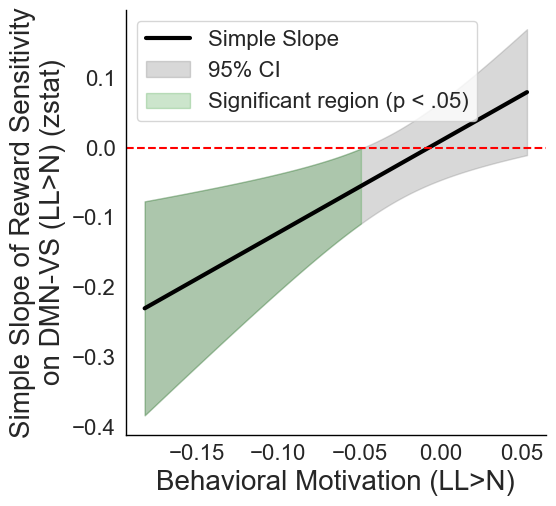


Linear Model Summary:
                               OLS Regression Results                              
Dep. Variable:     zstat_DMN_VS_LL_minus_N   R-squared:                       0.209
Model:                                 OLS   Adj. R-squared:                  0.132
Method:                      Least Squares   F-statistic:                     2.711
Date:                     Thu, 15 May 2025   Prob (F-statistic):             0.0430
Time:                             16:33:23   Log-Likelihood:                -30.847
No. Observations:                       46   AIC:                             71.69
Df Residuals:                           41   BIC:                             80.84
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
from scipy.stats import norm

# Set seaborn style
sns.set_style("white", {"axes.linecolor": "black", "axes.edgecolor": "black"})

# Load data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Drop missing values
df_plot = df[['comp_RS', 'zstat_DMN_VS_LL_minus_N', 'score_teps_ant', 'LL_N_new']].dropna().copy()

if df_plot.empty:
    print("Error: No valid data after dropping missing values. Cannot create plot.")
else:
    # Fit linear model
    model = smf.ols('zstat_DMN_VS_LL_minus_N ~ score_teps_ant + comp_RS * LL_N_new', data=df_plot).fit()

    # Extract model parameters and covariance matrix
    params = model.params
    cov = model.cov_params()

    # Define range of LL_N_new values
    ll_n_range = np.linspace(df_plot['LL_N_new'].min(), df_plot['LL_N_new'].max(), 100)

    # Calculate simple slopes, standard errors, and p-values
    simple_slopes = []
    se_slopes = []
    pvals = []

    for value in ll_n_range:
        # Simple slope of comp_RS at LL_N_new = value
        slope = params['comp_RS'] + params['comp_RS:LL_N_new'] * value

        # Compute standard error of the simple slope
        se = np.sqrt(
            cov.loc['comp_RS', 'comp_RS'] +
            2 * value * cov.loc['comp_RS', 'comp_RS:LL_N_new'] +
            value ** 2 * cov.loc['comp_RS:LL_N_new', 'comp_RS:LL_N_new']
        )
        se_slopes.append(se)

        # Compute p-value for test of slope = 0
        tval = slope / se
        pval = 2 * (1 - norm.cdf(np.abs(tval)))
        pvals.append(pval)

        simple_slopes.append(slope)

    simple_slopes = np.array(simple_slopes)
    se_slopes = np.array(se_slopes)
    pvals = np.array(pvals)

    # Calculate confidence intervals (95%)
    ci_lower = simple_slopes - 1.96 * se_slopes
    ci_upper = simple_slopes + 1.96 * se_slopes

    # Create J-N plot
    plt.figure(figsize=(5.5, 5))
    plt.plot(ll_n_range, simple_slopes, color='black', linewidth=3, label='Simple Slope')
    plt.fill_between(ll_n_range, ci_lower, ci_upper, color='gray', alpha=0.3, label='95% CI')

    # Highlight significant regions (p < 0.05)
    plt.fill_between(
        ll_n_range, ci_lower, ci_upper,
        where=(pvals < 0.05), color='green', alpha=0.2, label='Significant region (p < .05)'
    )

    # Add horizontal line at slope = 0
    plt.axhline(0, color='red', linestyle='--', linewidth=1.5)

    # Formatting
    plt.xlabel('Behavioral Motivation (LL>N)', fontsize=20)
    plt.ylabel('Simple Slope of Reward Sensitivity\non DMN-VS (LL>N) (zstat)', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16, loc='best')
    plt.xlim(ll_n_range.min() - 0.05 * (ll_n_range.max() - ll_n_range.min()),
             ll_n_range.max() + 0.05 * (ll_n_range.max() - ll_n_range.min()))
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.gca().spines[['left', 'bottom']].set_color('black')
    plt.gca().spines[['left', 'bottom']].set_linewidth(1)
    plt.gca().set_facecolor('white')
    plt.grid(False)

    plt.tight_layout(pad=0.5)
    plt.savefig('jn_plot_comp_rs_ll_n_new.svg', format='svg')
    plt.show()

    # Print linear model summary
    print("\nLinear Model Summary:")
    print(model.summary())

    # Print regions of significance
    print("\nJohnson-Neyman Analysis:")
    sig_points = ll_n_range[pvals < 0.05]
    if len(sig_points) > 0:
        print(f"Regions of significance (p < 0.05) for LL_N_new: {sig_points.min():.3f} to {sig_points.max():.3f}")
    else:
        print("No regions of significance found (p >= 0.05 for all LL_N_new values).")

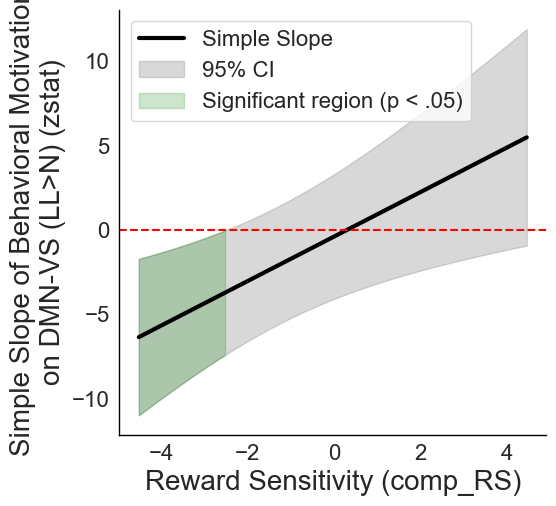


Linear Model Summary:
                               OLS Regression Results                              
Dep. Variable:     zstat_DMN_VS_LL_minus_N   R-squared:                       0.209
Model:                                 OLS   Adj. R-squared:                  0.132
Method:                      Least Squares   F-statistic:                     2.711
Date:                     Thu, 15 May 2025   Prob (F-statistic):             0.0430
Time:                             19:00:18   Log-Likelihood:                -30.847
No. Observations:                       46   AIC:                             71.69
Df Residuals:                           41   BIC:                             80.84
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
from scipy.stats import norm

# Set seaborn style
sns.set_style("white", {"axes.linecolor": "black", "axes.edgecolor": "black"})

# Load data
file_path = '~/Documents/Github/istart-mid-clean/code/total_df_n46.xlsx'
df = pd.read_excel(file_path)

# Drop missing values
df_plot = df[['comp_RS', 'zstat_DMN_VS_LL_minus_N', 'score_teps_ant', 'LL_N_new']].dropna().copy()

if df_plot.empty:
    print("Error: No valid data after dropping missing values. Cannot create plot.")
else:
    # Fit linear model
    model = smf.ols('zstat_DMN_VS_LL_minus_N ~ score_teps_ant + comp_RS * LL_N_new', data=df_plot).fit()

    # Extract model parameters and covariance matrix
    params = model.params
    cov = model.cov_params()

    # Define range of comp_RS values
    rs_range = np.linspace(df_plot['comp_RS'].min(), df_plot['comp_RS'].max(), 100)

    # Calculate simple slopes, standard errors, and p-values
    slopes = []
    se_slopes = []
    pvals = []

    for value in rs_range:
        # Simple slope of LL_N_new at comp_RS = value
        slope = params['LL_N_new'] + params['comp_RS:LL_N_new'] * value

        # Compute standard error of the simple slope
        se = np.sqrt(
            cov.loc['LL_N_new', 'LL_N_new'] +
            2 * value * cov.loc['LL_N_new', 'comp_RS:LL_N_new'] +
            value ** 2 * cov.loc['comp_RS:LL_N_new', 'comp_RS:LL_N_new']
        )
        se_slopes.append(se)

        # Compute p-value for test of slope = 0
        tval = slope / se
        pval = 2 * (1 - norm.cdf(np.abs(tval)))
        pvals.append(pval)

        slopes.append(slope)

    slopes = np.array(slopes)
    se_slopes = np.array(se_slopes)
    pvals = np.array(pvals)

    # Calculate confidence intervals (95%)
    ci_lower = slopes - 1.96 * se_slopes
    ci_upper = slopes + 1.96 * se_slopes

    # Create J-N plot
    plt.figure(figsize=(5.5, 5))
    plt.plot(rs_range, slopes, color='black', linewidth=3, label='Simple Slope')
    plt.fill_between(rs_range, ci_lower, ci_upper, color='gray', alpha=0.3, label='95% CI')

    # Highlight significant regions (p < 0.05)
    plt.fill_between(
        rs_range, ci_lower, ci_upper,
        where=(pvals < 0.05), color='green', alpha=0.2, label='Significant region (p < .05)'
    )

    # Add horizontal line at slope = 0
    plt.axhline(0, color='red', linestyle='--', linewidth=1.5)

    # Formatting
    plt.xlabel('Reward Sensitivity (comp_RS)', fontsize=20)
    plt.ylabel('Simple Slope of Behavioral Motivation\non DMN-VS (LL>N) (zstat)', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16, loc='best')
    plt.xlim(rs_range.min() - 0.05 * (rs_range.max() - rs_range.min()),
             rs_range.max() + 0.05 * (rs_range.max() - rs_range.min()))
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.gca().spines[['left', 'bottom']].set_color('black')
    plt.gca().spines[['left', 'bottom']].set_linewidth(1)
    plt.gca().set_facecolor('white')
    plt.grid(False)

    plt.tight_layout(pad=0.5)
    plt.savefig('jn_plot_comp_rs_ll_n_new.svg', format='svg')
    plt.show()

    # Print linear model summary
    print("\nLinear Model Summary:")
    print(model.summary())

    # Print regions of significance
    print("\nJohnson-Neyman Analysis:")
    sig_points = rs_range[pvals < 0.05]
    if len(sig_points) > 0:
        print(f"Regions of significance (p < 0.05) for comp_RS: {sig_points.min():.3f} to {sig_points.max():.3f}")
    else:
        print("No regions of significance found (p >= 0.05 for all comp_RS values).")

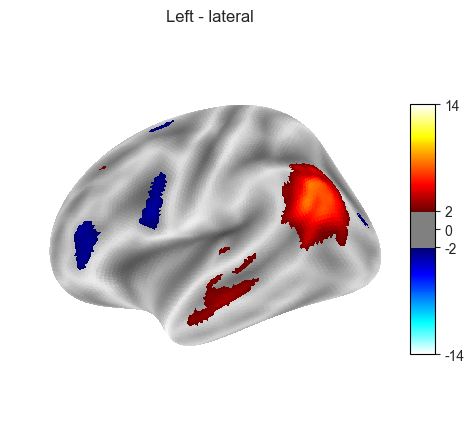

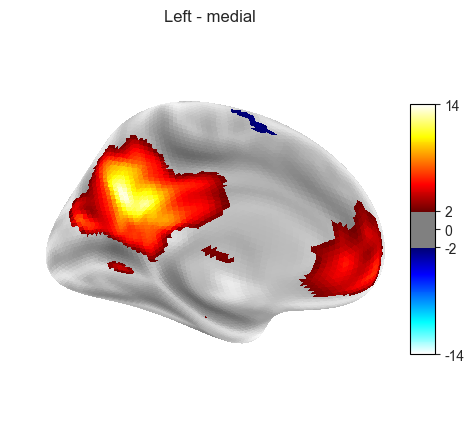

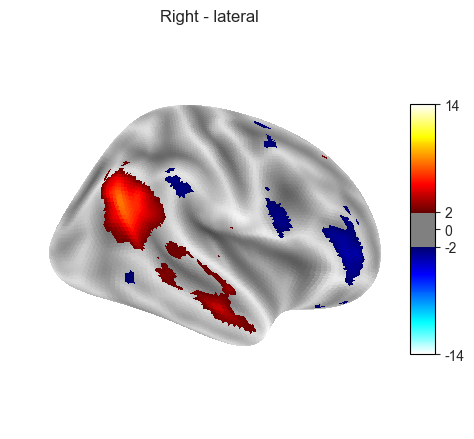

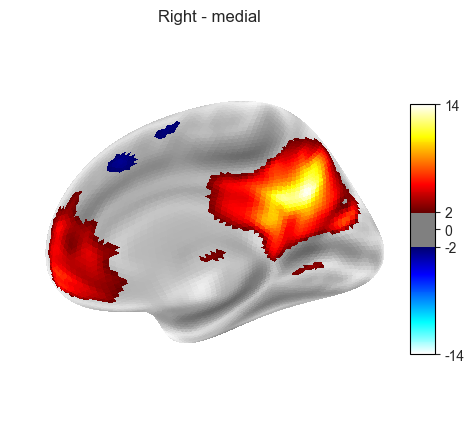

In [59]:
from nilearn import plotting, datasets, surface, image

# Step 1: Load the fsaverage cortical surface
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')  # 'fsaverage' is also available but heavier

# Step 2: Load your MNI-space statistical map
stat_map_nii = os.path.expanduser('~/Documents/Github/istart-mid-clean/masks/networkmasks/nan_rPNAS_2mm_net0003.nii.gz')

# Step 3: Project volume to surface (left and right)
texture_left = surface.vol_to_surf(stat_map_nii, fsaverage.pial_left)
texture_right = surface.vol_to_surf(stat_map_nii, fsaverage.pial_right)

# Step 4: Plot lateral and medial views for both hemispheres
views = ['lateral', 'medial']
for hemi, texture, surf, sulc in zip(
    ['left', 'right'],
    [texture_left, texture_right],
    [fsaverage.infl_left, fsaverage.infl_right],
    [fsaverage.sulc_left, fsaverage.sulc_right],
):
    for view in views:
        plotting.plot_surf_stat_map(
            surf_mesh=surf,
            stat_map=texture,
            hemi=hemi,
            view=view,
            bg_map=sulc,
            threshold=2.0,          # adjust based on your data
            cmap='cold_hot',        # red-yellow for +, blue for -
            colorbar=True,
            title=f'{hemi.capitalize()} - {view}'
        )

plotting.show()
